# RNN Based Models
Bidirectional is better

The output of the Bidirectional RNN will be, by default, the concatenation of the forward layer output and the backward layer output.

In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from models import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc
import librosa.display
import librosa as lr
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from hyperparams import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, LogMelSpectrogram, Spectrogram
from utils import *

# Set seed for experiment reproducibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

2021-08-27 20:58:25.810170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# _SMOKE_SIZE_ = 10000
_SMOKE_SIZE_ = -1

In [3]:
current_task = _TASKS_[0]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    make_and_save_original_splits(current_task, return_canonical_test_set=False)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task, smoke_size=_SMOKE_SIZE_)

X_test_can, y_test_can = get_canonical_10kwstask_test_set()

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

10kws+U+S
Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['marvin', 'tree', 'backward', 'one', 'three', 'four', 'two', 'six', 'forward', 'happy', 'wow', 'dog', 'sheila', 'five', 'bird', 'cat', 'house', 'zero', 'eight', 'seven', 'learn', 'follow', 'bed', 'visual', 'nine']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']
Samples in Training Set: 36921
Samples in Test Set: 4888
Samples in Validation Set: 4443


In [1]:
# visualize_class_balance(y_train,y_valid,output_classes)

In [5]:
batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size,
                            task=current_task)

#canonical test set
test_dataset_can = create_dataset(X_test_can, y_test_can, batch_size, is_test=True)


2021-08-27 20:58:28.020292: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-27 20:58:28.073189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 20:58:28.073497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-27 20:58:28.073525: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 20:58:28.076268: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 20:58:28.076415: I tensorflow/stream_executor/platf

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Train steps: 577
Validations steps: 70
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00915605, -0.00400629,  0.01090463, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33533737, -0.16095462, -0.09274575, ..., -0.00674459,
        -0.07974487,  0.06259346],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.02601908,
        -0.02168257, -0.01734605],
       [ 0.        ,  0.        ,  0.        , ..., -0.00596854,
        -0.00201024, -0.00207241]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([ 5,  8, 11,  4,  1, 11,  0,  5,  9, 11,  4, 10,  1,  3,  8,

2021-08-27 20:58:29.525461: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-27 20:58:29.548924: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


In [6]:
# epochs = 40
epochs = 10
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3, monitor="val_out_layer_loss")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1, monitor="val_out_layer_loss")

## Attention based RNN

In [8]:
att_model = simple_attention_rnn(train_dataset, output_classes, mfccs=True, model_suffix="mfccs")
att_model.summary()

Input shape: (16000,)
Model: "simple_attention_rnn_mfccs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment (RandomNoi (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           random_noise_augment[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 40, 1)    4           mfcc[0][0]                       
___________________________________________________

In [6]:
att_model.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = att_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

NameError: name 'att_model' is not defined

In [26]:
y_scores = att_model.predict(test_dataset)[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 50.000%


## Attention model from paper

In [11]:
model_att_andreade = attention_rnn_andreade(train_dataset, output_classes, "test_train", mfccs=True)
model_att_andreade.summary()

Input shape: (16000,)
Model: "andreade_original_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_1 (RandomN (None, 16000)        0           input_2[0][0]                    
__________________________________________________________________________________________________
mfcc_1 (MFCC)                   (None, 98, 40, 1)    0           random_noise_augment_1[0][0]     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 40, 1)    4           mfcc_1[0][0]                     
_________________________________________________

In [12]:
model_att_andreade.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = model_att_andreade.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/10


2021-08-27 19:35:22.247175: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 4912906240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


577/577 [==============================] - ETA: 0s - loss: 1.1343 - out_layer_loss: 1.1343 - out_layer_accuracy: 0.6157

2021-08-27 19:36:01.989012: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 4912906240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


577/577 [==============================] - 45s 69ms/step - loss: 1.1343 - out_layer_loss: 1.1343 - out_layer_accuracy: 0.6157 - val_loss: 0.4566 - val_out_layer_loss: 0.4566 - val_out_layer_accuracy: 0.8567
Epoch 2/10
577/577 [==============================] - 38s 67ms/step - loss: 0.6114 - out_layer_loss: 0.6114 - out_layer_accuracy: 0.7985 - val_loss: 0.3607 - val_out_layer_loss: 0.3607 - val_out_layer_accuracy: 0.8804
Epoch 3/10
577/577 [==============================] - 39s 67ms/step - loss: 0.4996 - out_layer_loss: 0.4996 - out_layer_accuracy: 0.8328 - val_loss: 0.3093 - val_out_layer_loss: 0.3093 - val_out_layer_accuracy: 0.9020
Epoch 4/10
577/577 [==============================] - 39s 67ms/step - loss: 0.4361 - out_layer_loss: 0.4361 - out_layer_accuracy: 0.8541 - val_loss: 0.2666 - val_out_layer_loss: 0.2666 - val_out_layer_accuracy: 0.9141
Epoch 5/10
577/577 [==============================] - 39s 68ms/step - loss: 0.4002 - out_layer_loss: 0.4002 - out_layer_accuracy: 0.8664 - 

In [12]:
model_att_andreade.save_weights(hyperparams._MODELS_DIR_/current_task/model_att_andreade.name/f"{model_att_andreade.name}_weights")
# model_att_andreade.load_weights(hyperparams._MODELS_DIR_/current_task/model_att_andreade.name/f"{model_att_andreade.name}_weights")

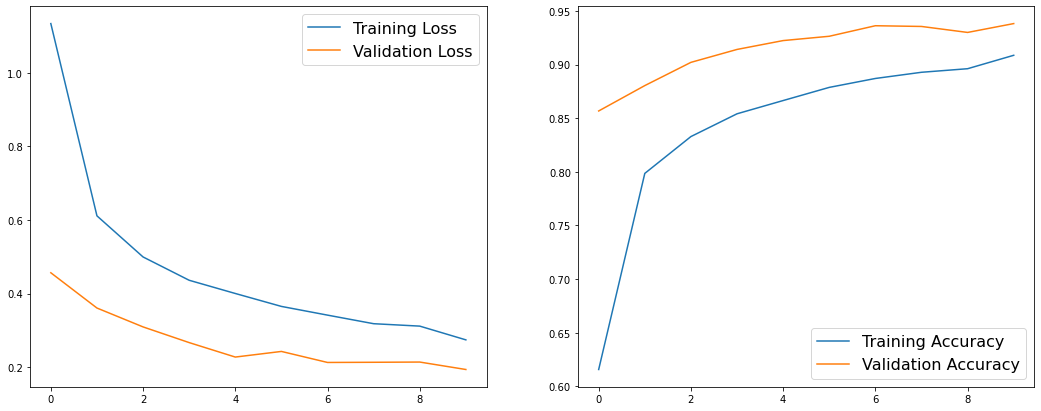

In [13]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_out_layer_loss'])), training_data['val_out_layer_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['out_layer_accuracy'])), training_data['out_layer_accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_out_layer_accuracy'])), training_data['val_out_layer_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

2021-08-27 19:43:06.126853: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 4912906240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 93.392%
Test set accuracy canonical test set: 92.004%


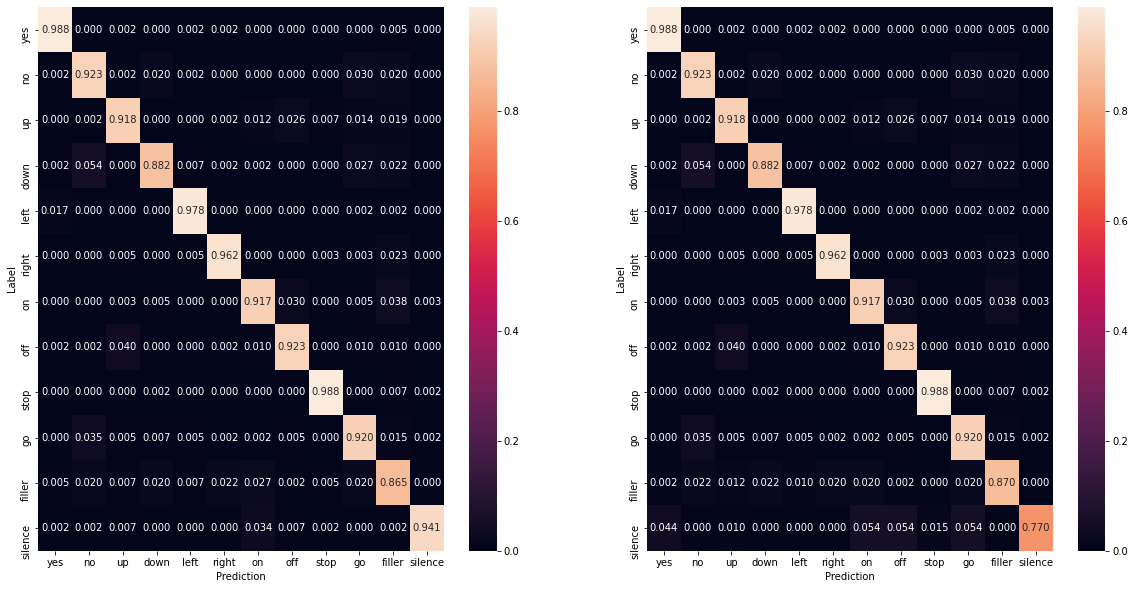

In [14]:
y_scores = model_att_andreade.predict(test_dataset.batch(batch_size))[0]
y_true = np.array(y_test)

# y_scores = model_att_andreade.predict(valid_dataset, steps=valid_steps)[0][:len(y_valid)]
# y_true = np.array(y_valid)

y_pred = np.array(np.argmax(y_scores, axis=1))
# compute test accuracy
test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".3f")
plt.xlabel('Prediction')
plt.ylabel('Label')

#canonical test set ----------------------------------------------------
y_scores2 = model_att_andreade.predict(test_dataset_can.batch(batch_size))[0]
y_true2 = np.array(y_test_can)

y_pred2 = np.array(np.argmax(y_scores2, axis=1))
# compute test accuracy
test_acc_can = sum(np.equal(y_pred2, y_true2)) / len(y_true2)
print(f'Test set accuracy canonical test set: {test_acc_can:.3%}')

plt.subplot(1,2,2)
confusion_mtx2 = confusion_matrix(y_true2, y_pred2, normalize='true') 
sns.heatmap(confusion_mtx2, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".3f")
plt.xlabel('Prediction')
plt.ylabel('Label')

plt.show()

In [12]:
X_test.shape

(4888,)

In [13]:
np.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([419, 405, 425, 406, 412, 396, 396, 402, 411, 402, 407, 407]))

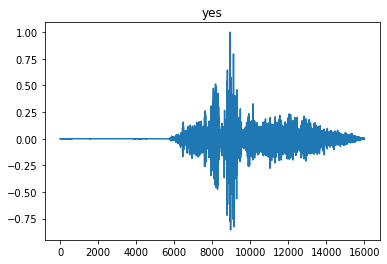

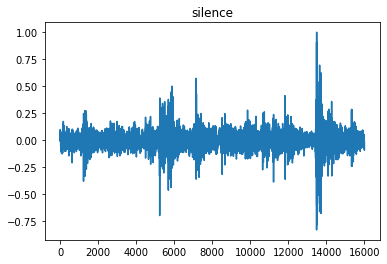

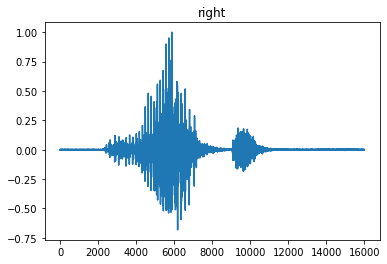

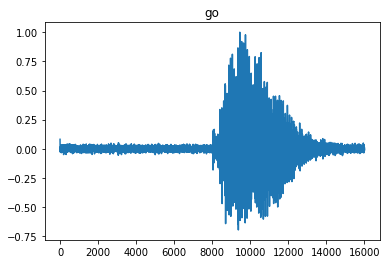

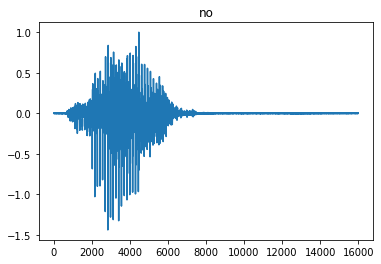

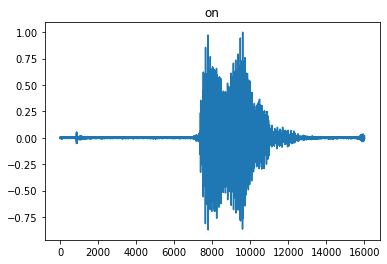

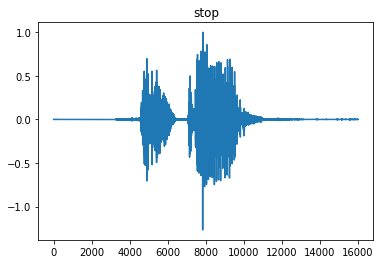

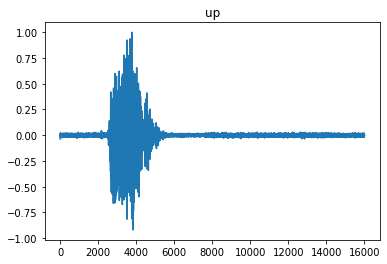

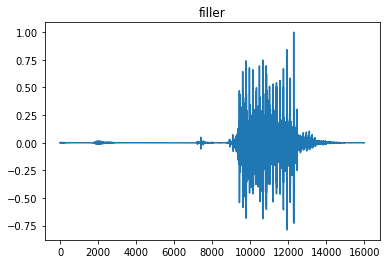

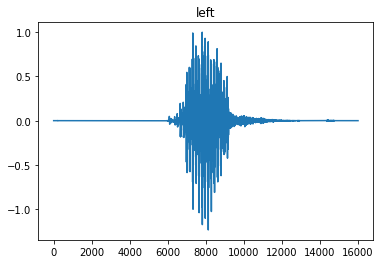

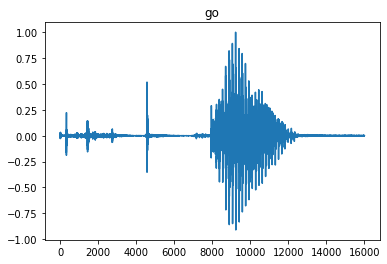

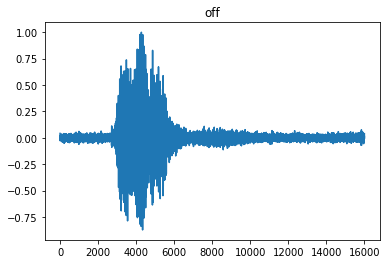

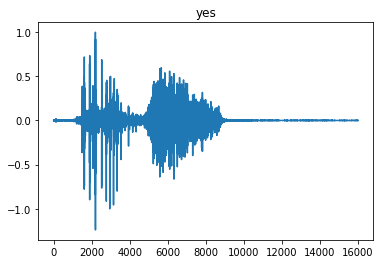

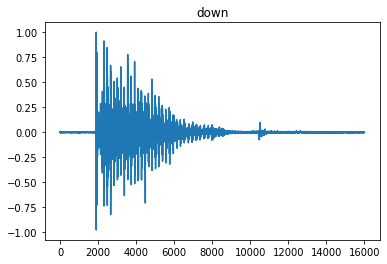

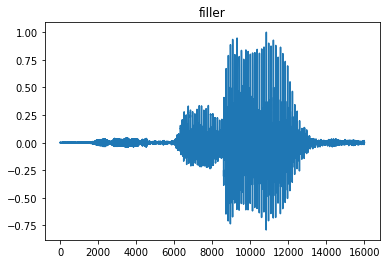

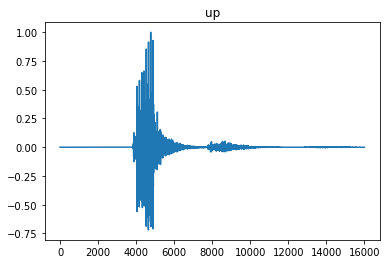

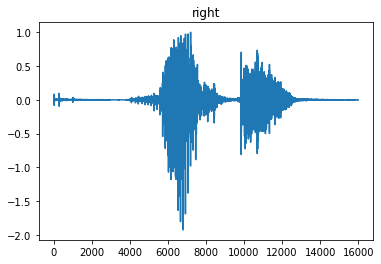

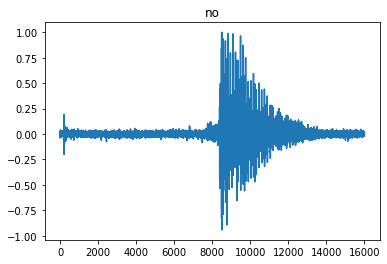

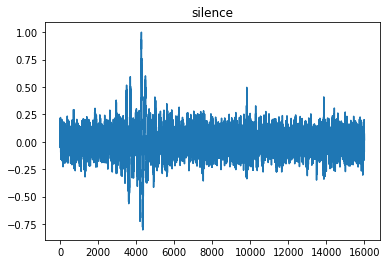

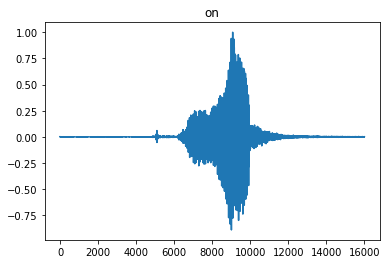

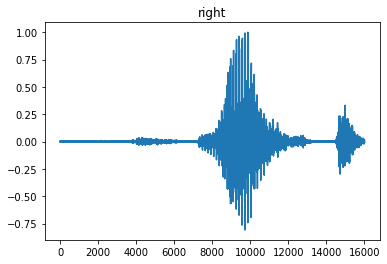

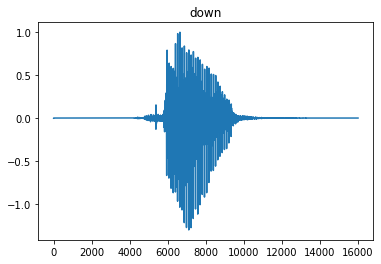

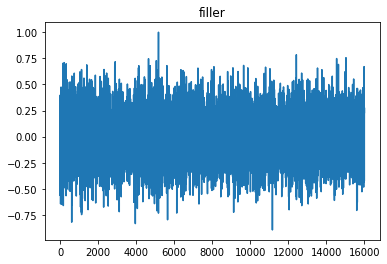

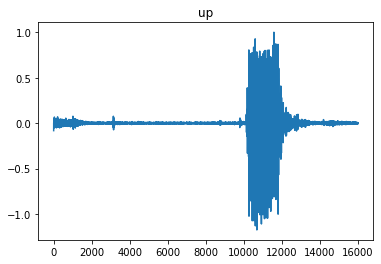

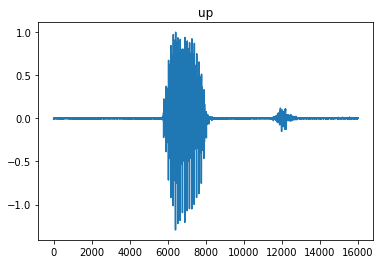

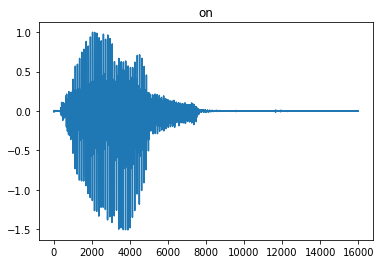

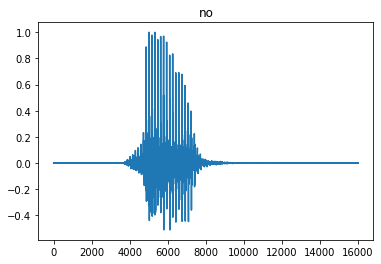

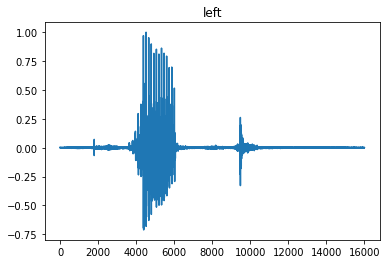

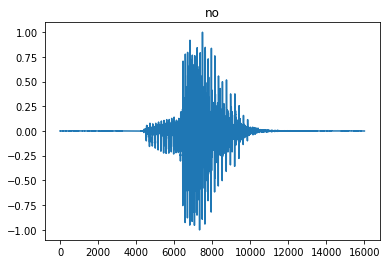

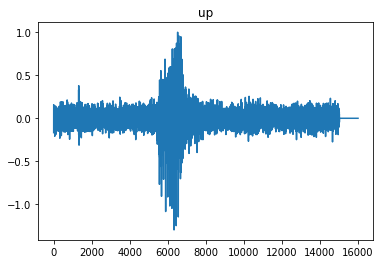

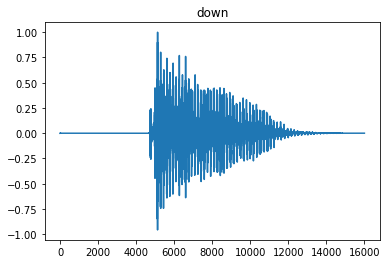

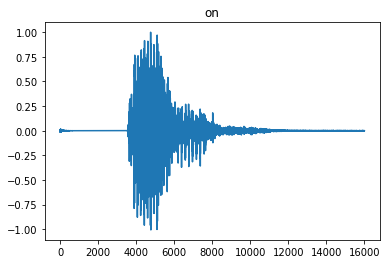

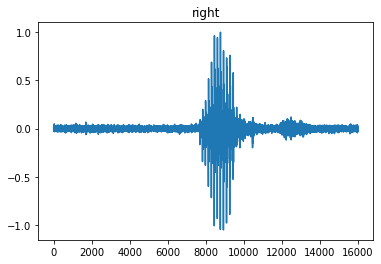

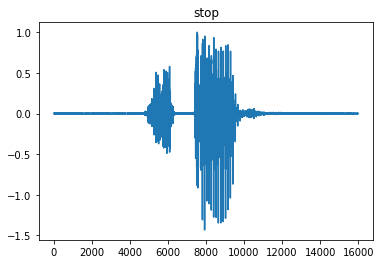

In [14]:
for i in test_dataset.take(50):
#     print(i)
    plt.plot(i[0])
    plt.title(output_classes[i[1]])
    plt.show()

In [47]:
def save_weights_and_results(model, history, test_dataset, X_test, y_test, current_task):
    #save model weights
    model.save_weights(hyperparams._MODELS_DIR_/current_task/model.name/f"{model.name}_weights")
    results={}
    #save attention scores and predictions
    y_scores, att_scores = model.predict(test_dataset.batch(len(X_test)))
    y_pred = np.array(np.argmax(y_scores, axis=1))
    y_true = np.array(y_test)
    # compute test accuracy
    test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
    print(f'Test set accuracy: {test_acc:.3%}')
    
    results["test_acc"] = test_acc
    results["attention_scores"] = att_scores
    results["prediction_scores"] = y_scores
    results["train_history"] = history.history
    with open(hyperparams._MODELS_DIR_/current_task/model.name/f'results_{model.name}.pkl', 'wb') as outp:
        pickle.dump(results, outp)
    return results

In [ ]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = model_att_andreade(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()

In [33]:
current_task

'10kws+U+S'

In [44]:
# model_att_andreade.save(hyperparams._MODELS_DIR_/current_task/f'{model_att_andreade.name}_{test_acc}.h5')
model_att_andreade.save(hyperparams._MODELS_DIR_/current_task/model_att_andreade.name)

INFO:tensorflow:Assets written to: models/10kws+U+S/andreade_original_test_train/assets


INFO:tensorflow:Assets written to: models/10kws+U+S/andreade_original_test_train/assets


In [45]:
# test = tf.keras.models.load_model(f'models/{current_task}/andreade_original_test_train')

## Attention from paper but with whole sequence as query

In [7]:
model_andreade_queries = attention_rnn_andreade_seq_query(train_dataset, output_classes, "andreade_test_mod")
model_andreade_queries.summary()

Input shape: (16000,)
Model: "andreade_seq_query_andreade_test_mod"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment (RandomNoi (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           random_noise_augment[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 40, 1)    4           mfcc[0][0]                       
_________________________________________

In [8]:
model_andreade_queries.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = model_andreade_queries.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/10


2021-08-27 20:48:27.380641: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5009440768 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-08-27 20:48:27.865211: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-27 20:48:27.952053: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 20:48:28.20083

577/577 [==============================] - ETA: 0s - loss: 1.6262 - out_layer_loss: 1.6262 - out_layer_accuracy: 0.4397

2021-08-27 20:49:07.681779: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5009440768 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


577/577 [==============================] - 46s 68ms/step - loss: 1.6262 - out_layer_loss: 1.6262 - out_layer_accuracy: 0.4397 - val_loss: 0.7886 - val_out_layer_loss: 0.7886 - val_out_layer_accuracy: 0.7359
Epoch 2/10
577/577 [==============================] - 37s 65ms/step - loss: 0.8701 - out_layer_loss: 0.8701 - out_layer_accuracy: 0.7083 - val_loss: 0.5267 - val_out_layer_loss: 0.5267 - val_out_layer_accuracy: 0.8252
Epoch 3/10
577/577 [==============================] - 38s 65ms/step - loss: 0.6981 - out_layer_loss: 0.6981 - out_layer_accuracy: 0.7674 - val_loss: 0.4199 - val_out_layer_loss: 0.4199 - val_out_layer_accuracy: 0.8636
Epoch 4/10
577/577 [==============================] - 39s 68ms/step - loss: 0.6225 - out_layer_loss: 0.6225 - out_layer_accuracy: 0.7919 - val_loss: 0.3730 - val_out_layer_loss: 0.3730 - val_out_layer_accuracy: 0.8761
Epoch 5/10
577/577 [==============================] - 39s 67ms/step - loss: 0.5626 - out_layer_loss: 0.5626 - out_layer_accuracy: 0.8143 - 

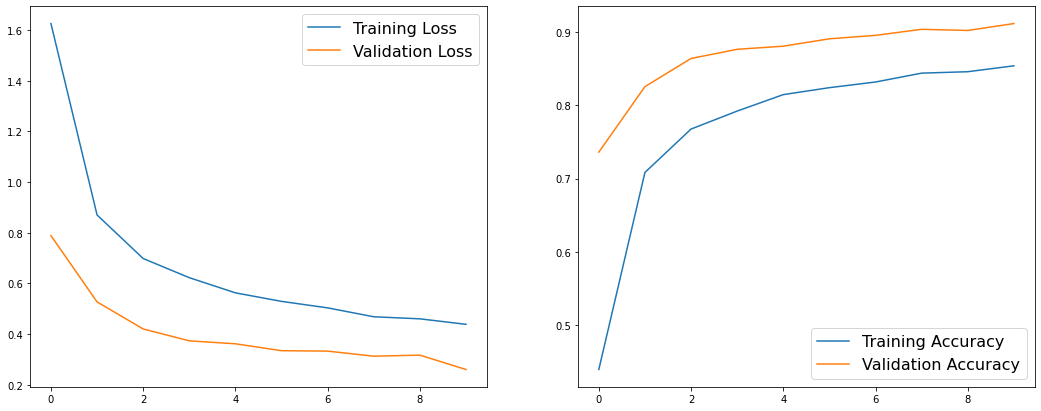

In [9]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_out_layer_loss'])), training_data['val_out_layer_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['out_layer_accuracy'])), training_data['out_layer_accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_out_layer_accuracy'])), training_data['val_out_layer_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [10]:
y_scores = model_andreade_queries.predict(test_dataset.batch(batch_size))[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

2021-08-27 20:56:41.805984: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5009440768 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 91.142%


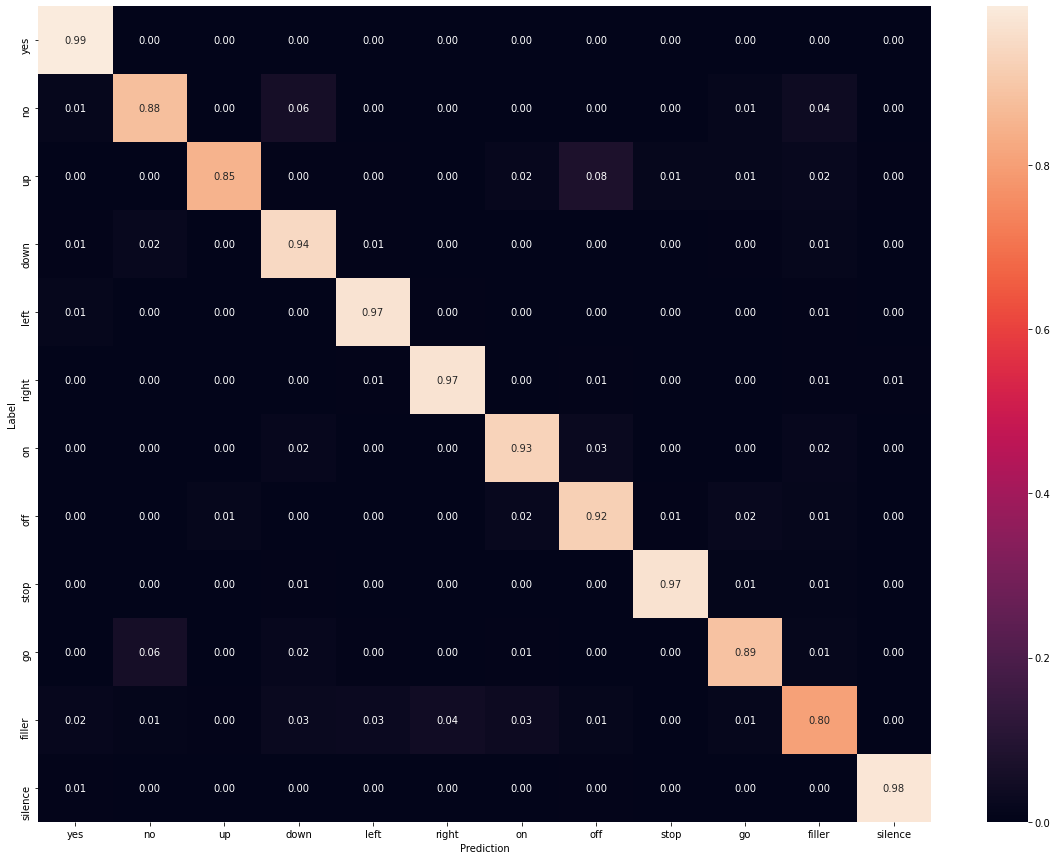

In [14]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 15))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
# plt.title(f"Model: {model.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model.name}.png', dpi=300)
plt.show()

In [ ]:
att_scores = model_andreade_queries.predict(test_dataset)[1]

In [ ]:
ex_att = att_scores[0]
ex_att = tf.constant(ex_att)
ex_att = tf.reduce_mean(ex_att, axis=0)

In [ ]:
plt.plot(ex_att)

In [ ]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = model_andreade_queries(ex)[1][0]
    atts = tf.reduce_mean(atts, axis=0)
#     print(atts)
#     
    plt.plot(np.log(atts + 0.000001))
    
    plt.show()

## Seq Query no CNN

In [8]:
seq_query_nocnn = andreade_seq_query_no_cnn(train_dataset, output_classes, "test_train", mfccs=True)
seq_query_nocnn.summary()

Input shape: (16000,)
Model: "andreade_seq_query_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment (RandomNoi (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           random_noise_augment[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 40, 1)    4           mfcc[0][0]                       
________________________________________________

In [8]:
seq_query_nocnn.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = seq_query_nocnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/10


2021-08-27 19:27:47.003118: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 4912906240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-08-27 19:27:47.515635: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-27 19:27:47.603215: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 19:27:47.84704

577/577 [==============================] - ETA: 0s - loss: 1.2559 - out_layer_loss: 1.2559 - out_layer_accuracy: 0.5784

2021-08-27 19:28:31.370422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-08-27 19:28:32.978220: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor

577/577 [==============================] - 58s 87ms/step - loss: 1.2559 - out_layer_loss: 1.2559 - out_layer_accuracy: 0.5784 - val_loss: 0.5254 - val_out_layer_loss: 0.5254 - val_out_layer_accuracy: 0.8297
Epoch 2/10
  1/577 [..............................] - ETA: 55s - loss: 0.6680 - out_layer_loss: 0.6680 - out_layer_accuracy: 0.8125

2021-08-27 19:28:38.812122: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


577/577 [==============================] - 39s 68ms/step - loss: 0.6651 - out_layer_loss: 0.6651 - out_layer_accuracy: 0.7792 - val_loss: 0.3813 - val_out_layer_loss: 0.3813 - val_out_layer_accuracy: 0.8839
Epoch 3/10
577/577 [==============================] - 39s 68ms/step - loss: 0.5578 - out_layer_loss: 0.5578 - out_layer_accuracy: 0.8134 - val_loss: 0.3368 - val_out_layer_loss: 0.3368 - val_out_layer_accuracy: 0.8980
Epoch 4/10
577/577 [==============================] - 40s 69ms/step - loss: 0.4835 - out_layer_loss: 0.4835 - out_layer_accuracy: 0.8409 - val_loss: 0.2967 - val_out_layer_loss: 0.2967 - val_out_layer_accuracy: 0.9114
Epoch 5/10
577/577 [==============================] - 39s 68ms/step - loss: 0.4433 - out_layer_loss: 0.4433 - out_layer_accuracy: 0.8546 - val_loss: 0.2713 - val_out_layer_loss: 0.2713 - val_out_layer_accuracy: 0.9165
Epoch 6/10
577/577 [==============================] - 39s 68ms/step - loss: 0.4107 - out_layer_loss: 0.4107 - out_layer_accuracy: 0.8635 - 

In [10]:
y_scores = seq_query_nocnn.predict(test_dataset.batch(batch_size))[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

2021-08-27 19:34:53.790819: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-08-27 19:34:55.019944: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor

Test set accuracy: 92.615%


## ResNet Andreade

In [7]:
resnet_andreade = resnet_andreade(train_dataset, output_classes, "andreade_test_mod", n_res_blocks=3)
resnet_andreade.summary()

Input shape: (16000,)
Model: "andreade_original_andreade_test_mod"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment (RandomNoi (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           random_noise_augment[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 40, 1)    4           mfcc[0][0]                       
__________________________________________

In [8]:
resnet_andreade.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = resnet_andreade.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/10


2021-08-27 20:25:26.495337: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5048172544 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-08-27 20:25:27.011795: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-27 20:25:27.096735: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 20:25:27.34231

577/577 [==============================] - ETA: 0s - loss: 1.6628 - out_layer_loss: 1.6628 - out_layer_accuracy: 0.4175

2021-08-27 20:26:13.706900: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5048172544 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


577/577 [==============================] - 54s 81ms/step - loss: 1.6628 - out_layer_loss: 1.6628 - out_layer_accuracy: 0.4175 - val_loss: 0.6831 - val_out_layer_loss: 0.6831 - val_out_layer_accuracy: 0.7679
Epoch 2/10
577/577 [==============================] - 47s 81ms/step - loss: 0.7872 - out_layer_loss: 0.7872 - out_layer_accuracy: 0.7364 - val_loss: 0.4444 - val_out_layer_loss: 0.4444 - val_out_layer_accuracy: 0.8565
Epoch 3/10
577/577 [==============================] - 45s 78ms/step - loss: 0.6152 - out_layer_loss: 0.6152 - out_layer_accuracy: 0.7948 - val_loss: 0.3325 - val_out_layer_loss: 0.3325 - val_out_layer_accuracy: 0.8929
Epoch 4/10
577/577 [==============================] - 46s 79ms/step - loss: 0.5208 - out_layer_loss: 0.5208 - out_layer_accuracy: 0.8247 - val_loss: 0.2958 - val_out_layer_loss: 0.2958 - val_out_layer_accuracy: 0.9056
Epoch 5/10
577/577 [==============================] - 45s 78ms/step - loss: 0.4610 - out_layer_loss: 0.4610 - out_layer_accuracy: 0.8446 - 

In [9]:
y_scores = resnet_andreade.predict(test_dataset.batch(batch_size))[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

2021-08-27 20:33:07.217480: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5048172544 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 92.901%


## Attention with Multi Head Attention module from Transformers

In [14]:
andreade_mha = mha_andreade(
                train_dataset,
                output_classes,
                model_suffix="test_train",
                mfccs=True,
                n_heads=5)
andreade_mha.summary()

Input shape: (16000,)
Model: "mha_andreade_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_2 (RandomN (None, 16000)        0           input_3[0][0]                    
__________________________________________________________________________________________________
mfcc_2 (MFCC)                   (None, 98, 40, 1)    0           random_noise_augment_2[0][0]     
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 98, 40, 1)    4           mfcc_2[0][0]                     
______________________________________________________

In [15]:
andreade_mha.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history =andreade_mha.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/10
577/577 [==============================] - 44s 65ms/step - loss: 2.0561 - out_layer_loss: 2.0561 - out_layer_accuracy: 0.2705 - val_loss: 1.7089 - val_out_layer_loss: 1.7089 - val_out_layer_accuracy: 0.4201
Epoch 2/10
577/577 [==============================] - 36s 63ms/step - loss: 1.2835 - out_layer_loss: 1.2835 - out_layer_accuracy: 0.5578 - val_loss: 0.8331 - val_out_layer_loss: 0.8331 - val_out_layer_accuracy: 0.7174
Epoch 3/10
577/577 [==============================] - 38s 66ms/step - loss: 0.9171 - out_layer_loss: 0.9171 - out_layer_accuracy: 0.6940 - val_loss: 0.6038 - val_out_layer_loss: 0.6038 - val_out_layer_accuracy: 0.7960
Epoch 4/10
577/577 [==============================] - 37s 64ms/step - loss: 0.7655 - out_layer_loss: 0.7655 - out_layer_accuracy: 0.7493 - val_loss: 0.4801 - val_out_layer_loss: 0.4801 - val_out_layer_accuracy: 0.8426
Epoch 5/10
577/577 [==============================] - 36s 63ms/step - loss: 0.6825 - out_layer_loss: 0.6825 - out_layer_accuracy

In [12]:
andreade_mha.save_weights(hyperparams._MODELS_DIR_/current_task/"test_mhaaa")
# andreade_mha.load_weights(hyperparams._MODELS_DIR_/current_task/"test_mhaaa")

In [16]:
y_scores = andreade_mha.predict(test_dataset.batch(batch_size))[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 89.935%


In [12]:
len(y_test)

1000

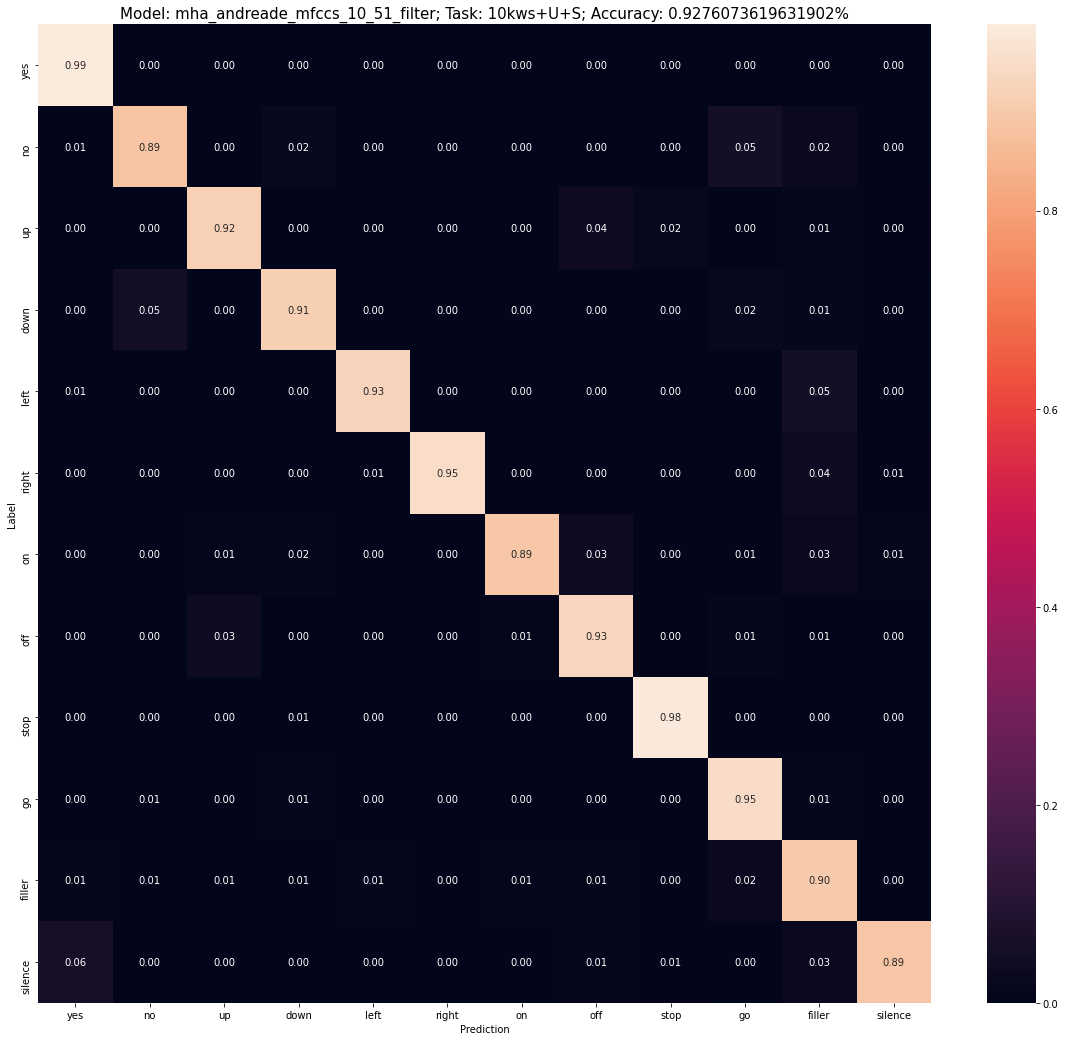

In [12]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {andreade_mha.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

In [20]:
yes_preds = np.where(y_pred==0)[0]
yes_true = np.where(y_true==0)[0]

In [24]:
wrongs = list(set(yes_preds).difference(set(yes_true)))

### Investigate wrong predictions...

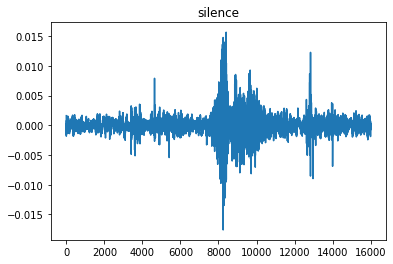

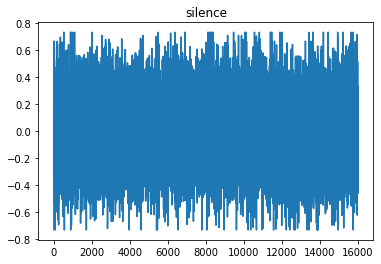

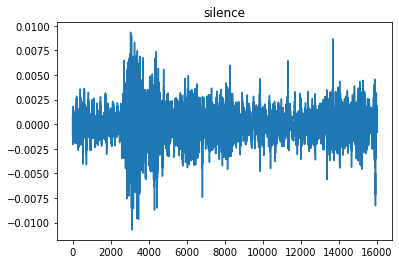

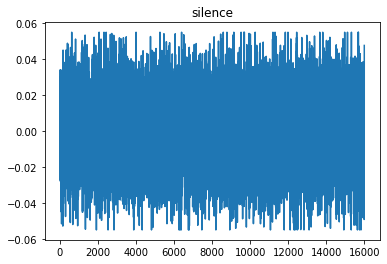

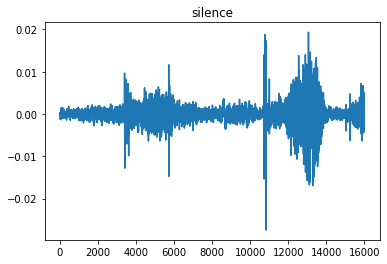

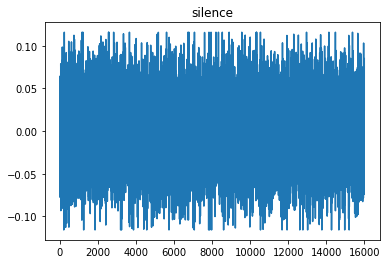

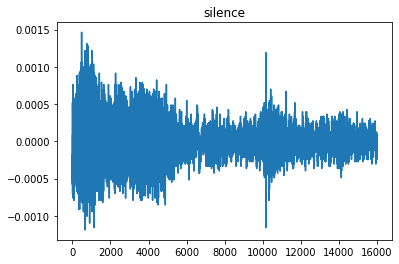

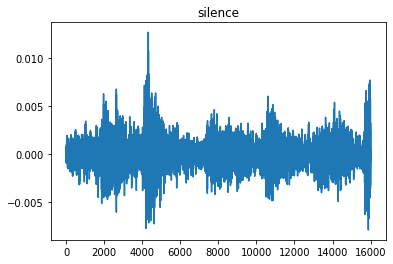

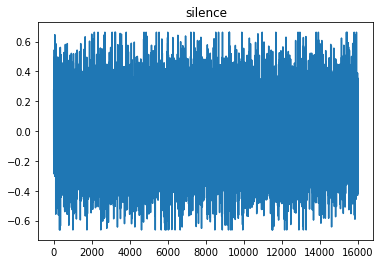

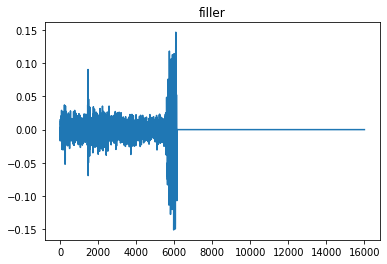

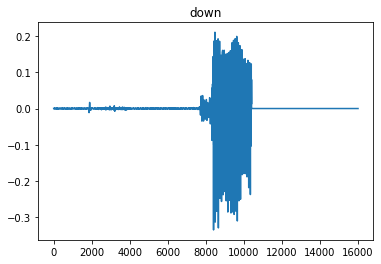

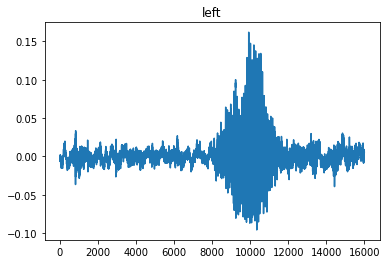

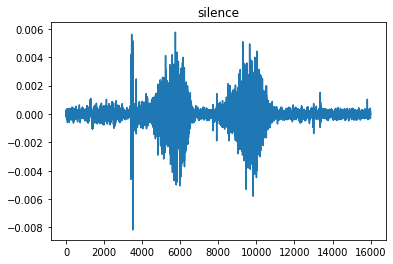

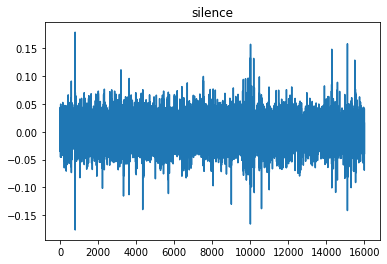

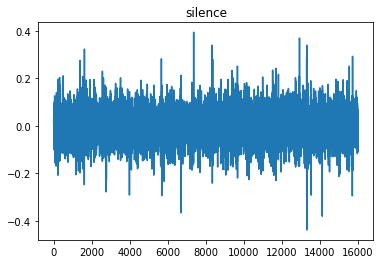

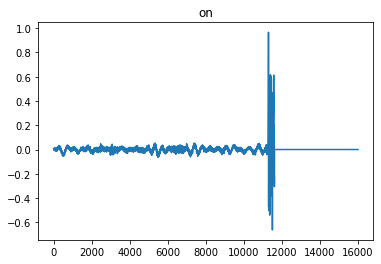

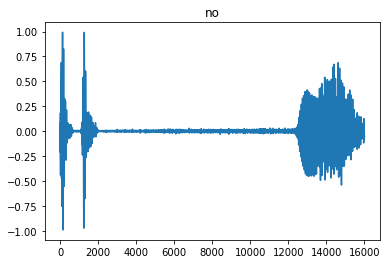

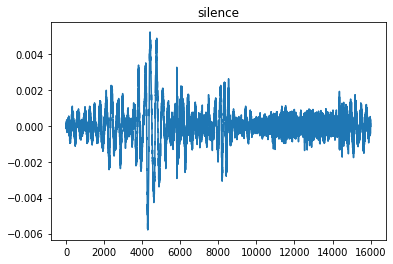

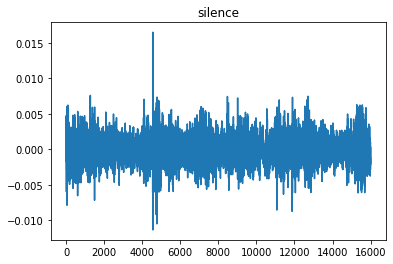

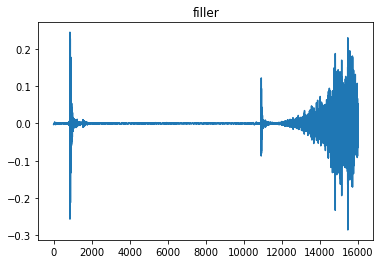

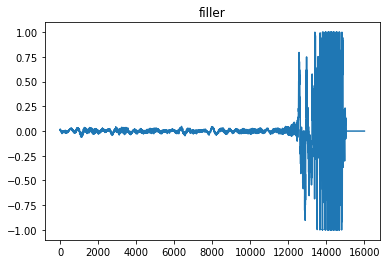

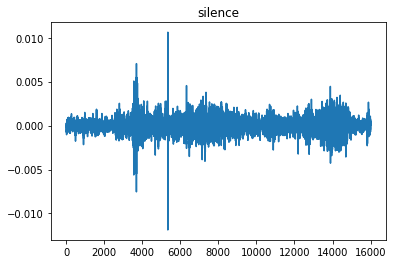

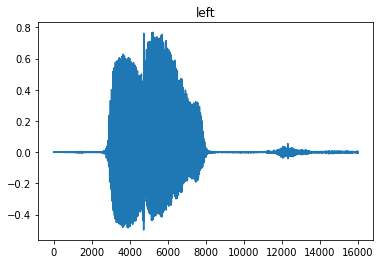

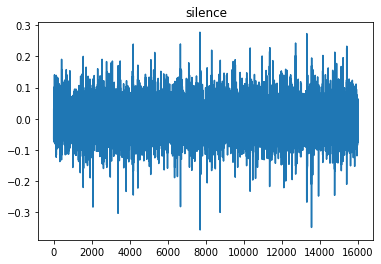

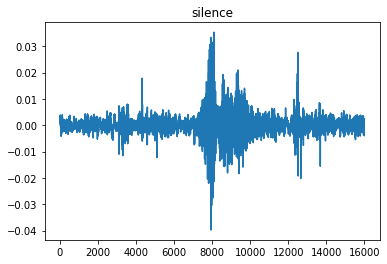

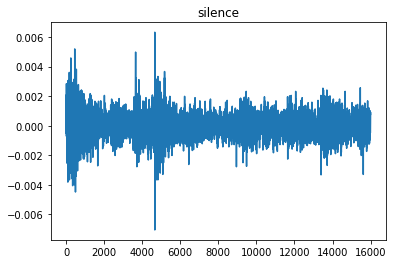

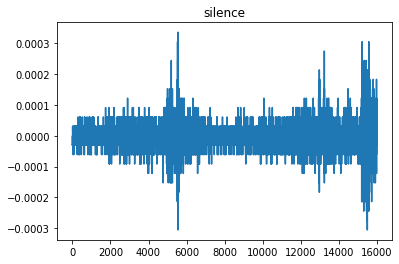

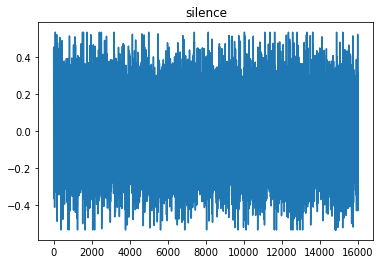

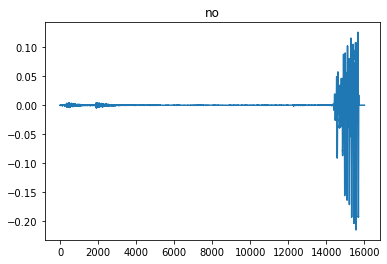

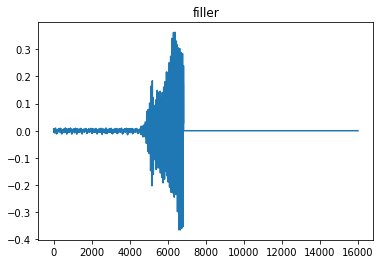

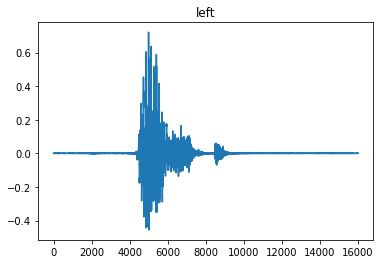

In [30]:
def get_test_label_int(audio_file_path):
        data_dir = pathlib.Path(os.path.sep.join(
            audio_file_path.split(os.path.sep)[:2]))
        _, _, output_classes = get_kws(data_dir, "10kws+U+S")
        file_path_names = audio_file_path.split(os.path.sep)
        kw = file_path_names[2]
        if kw == '_silence_':
            return np.argmax(_SILENCE_CLASS_ == np.array(output_classes))
        elif kw == '_unknown_':
            return np.argmax(_UNKNOWN_CLASS_ == np.array(output_classes))
        return np.argmax(kw == np.array(output_classes))

for i in wrongs:
    fname = X_test[i]
    w = decode_audio(fname)
    plt.plot(w)
    plt.title(output_classes[get_test_label_int(fname)])
    display.display(display.Audio(w, rate=16000))
    plt.show()

In [31]:
## attention scores
att_scores = andreade_mha.predict(test_dataset.batch(batch_size))[1]

2021-08-24 18:40:50.093136: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1314979680 exceeds 10% of free system memory.


In [36]:
atts = tf.reduce_mean(tf.reduce_mean(att_scores, axis=2), axis=1)

2021-08-24 18:42:31.516781: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1314979680 exceeds 10% of free system memory.


In [38]:
atts = np.log(atts + 0.000001)

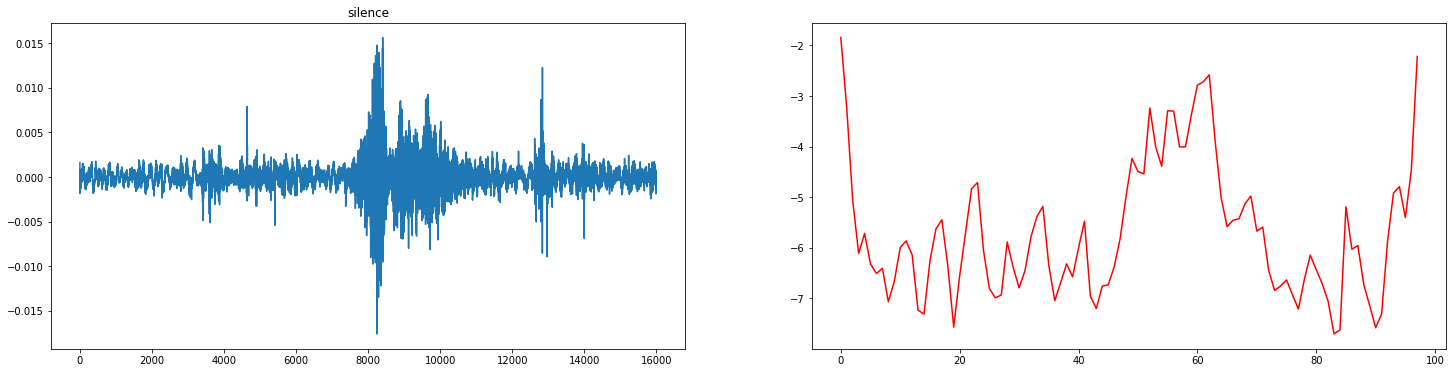

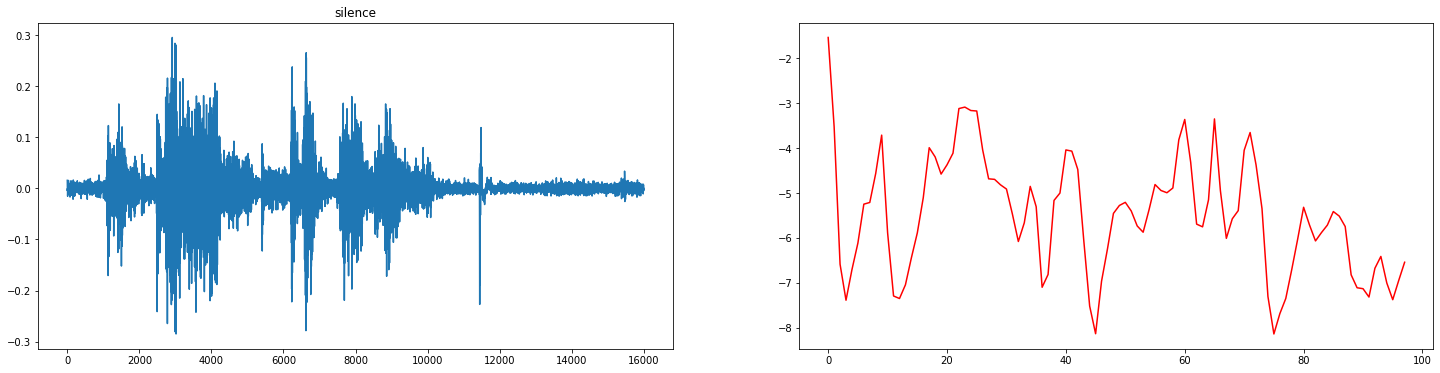

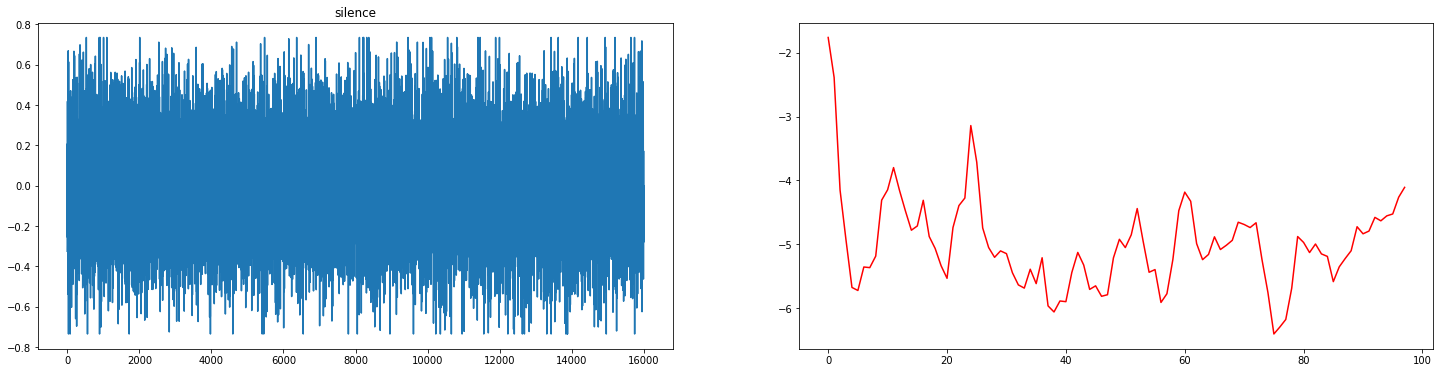

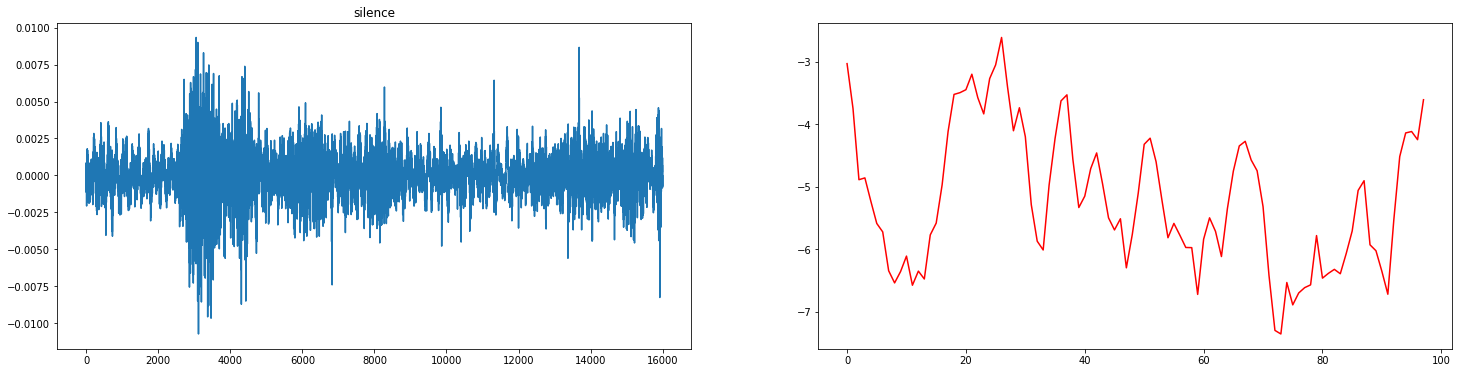

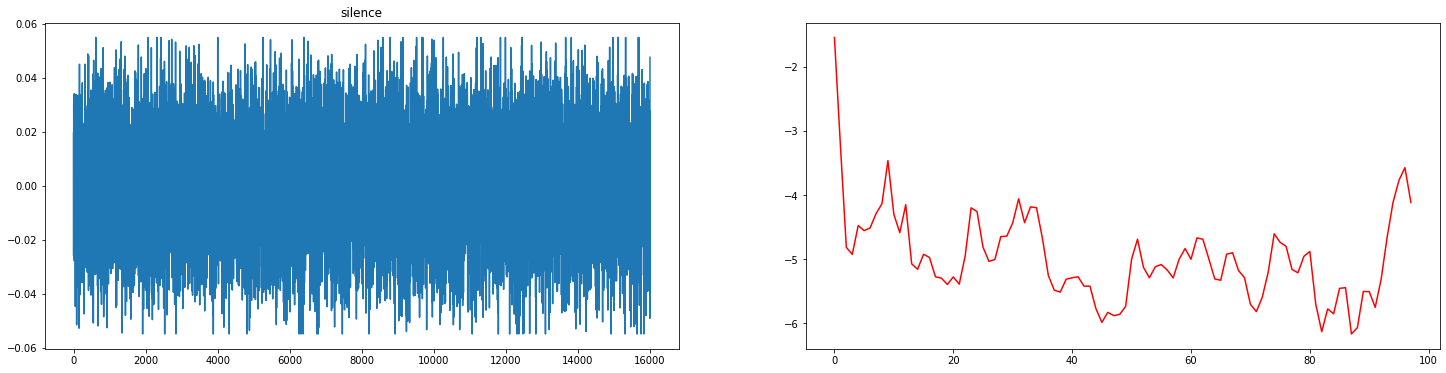

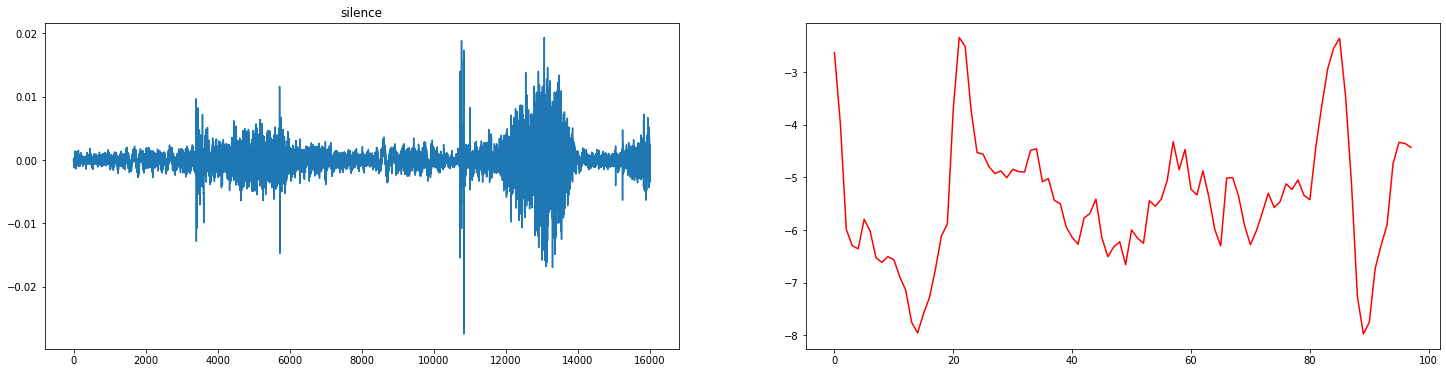

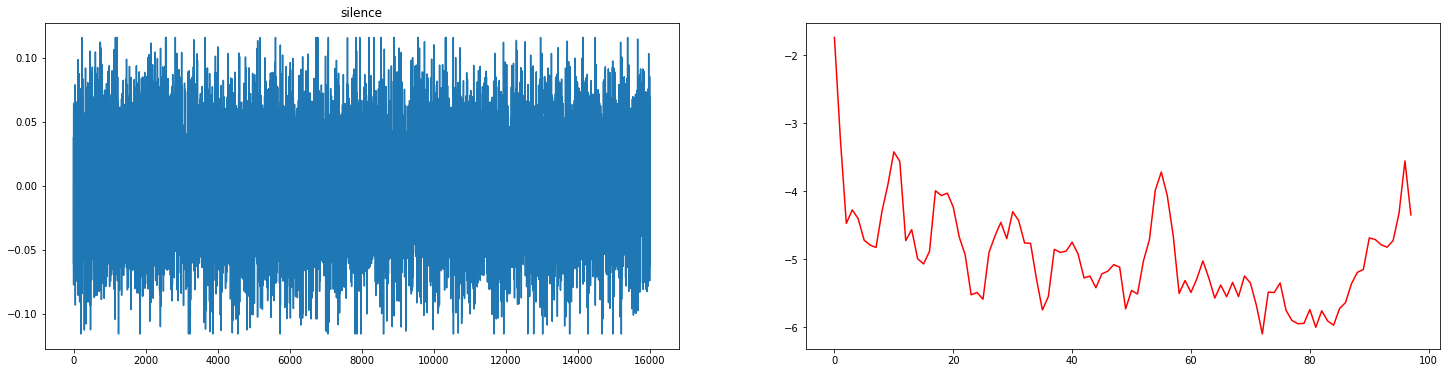

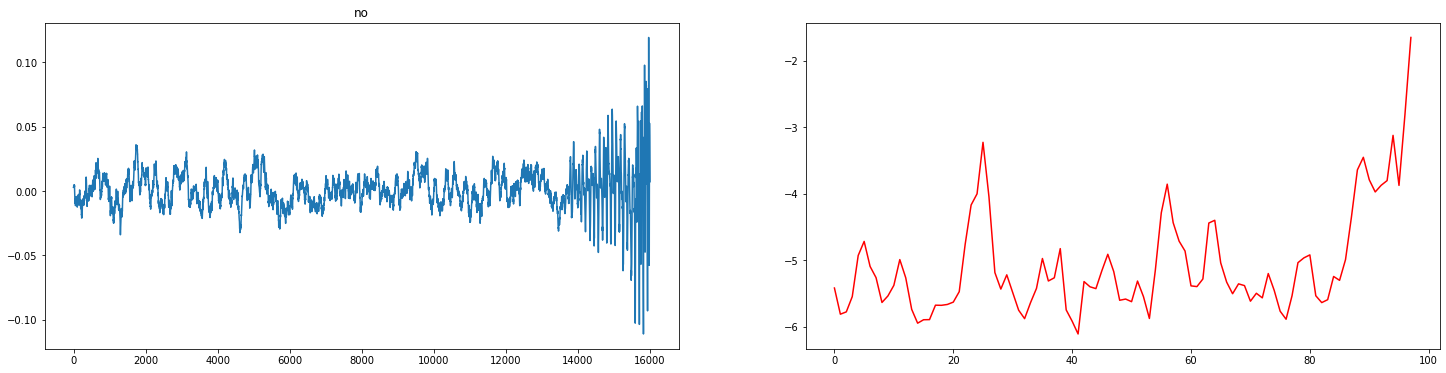

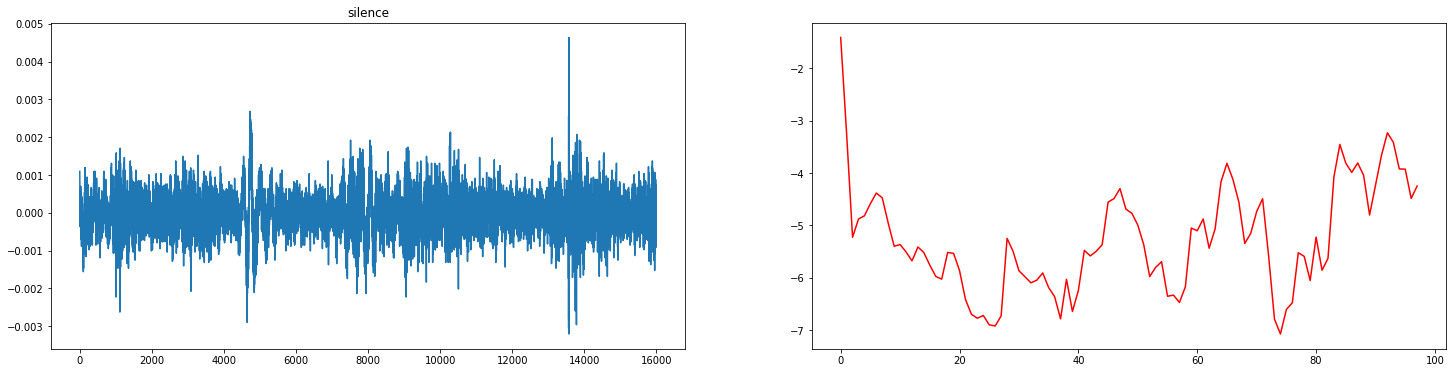

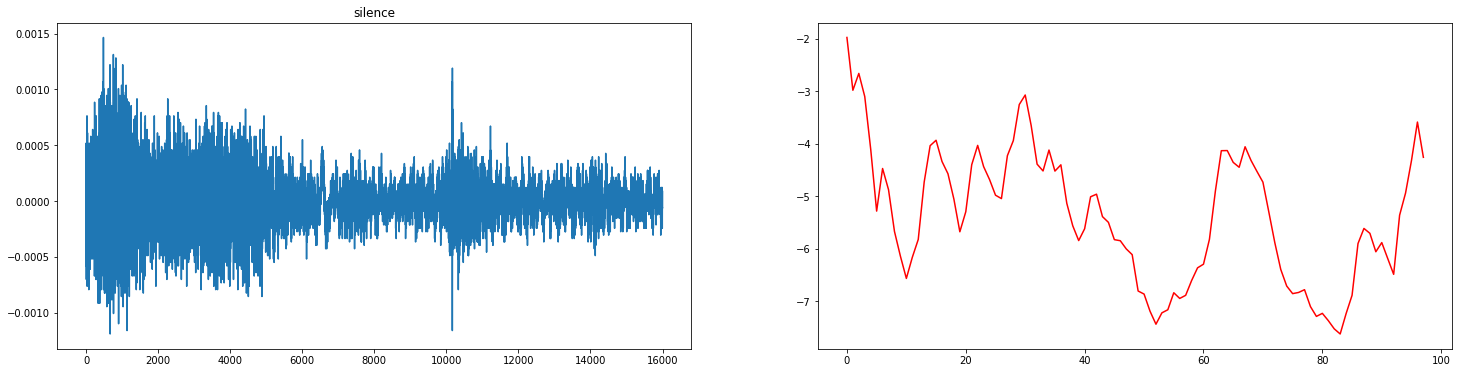

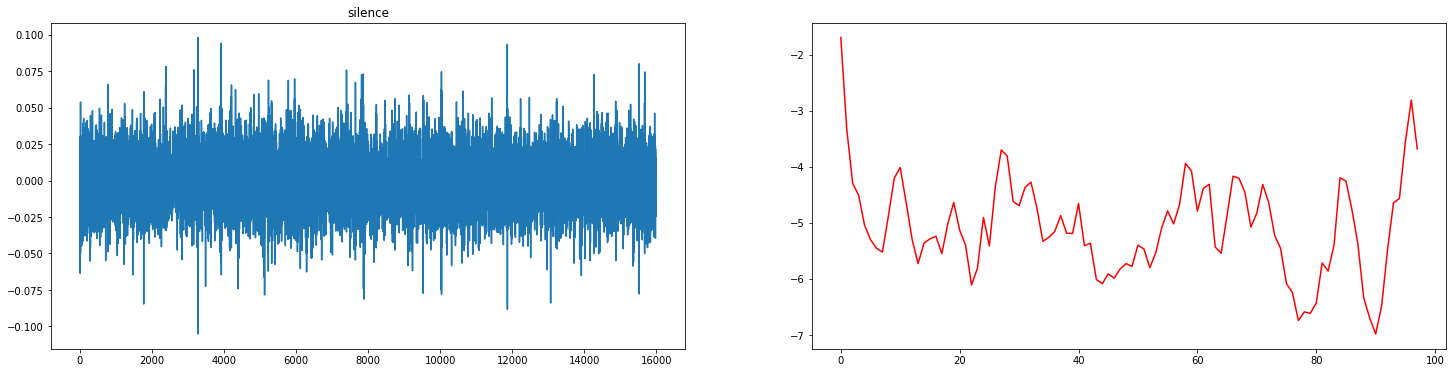

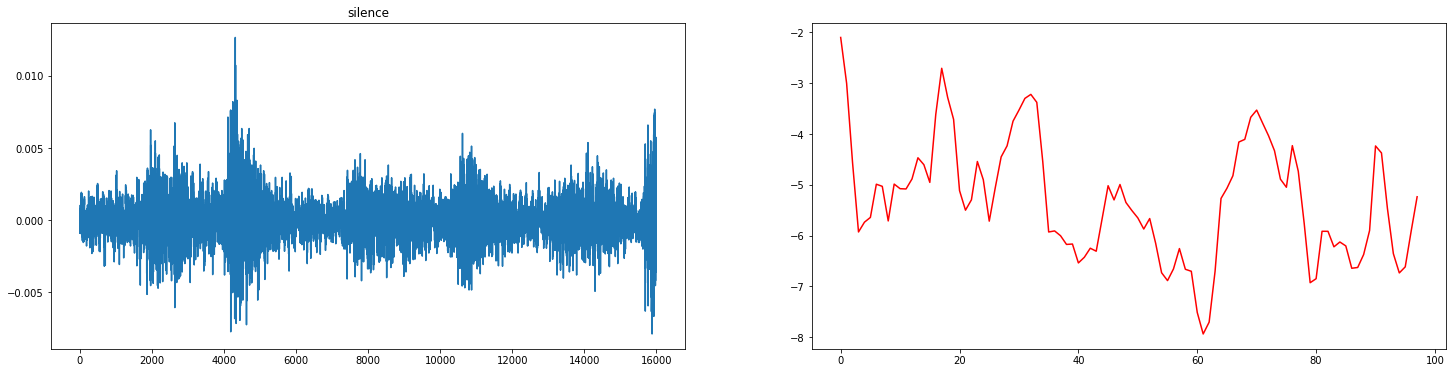

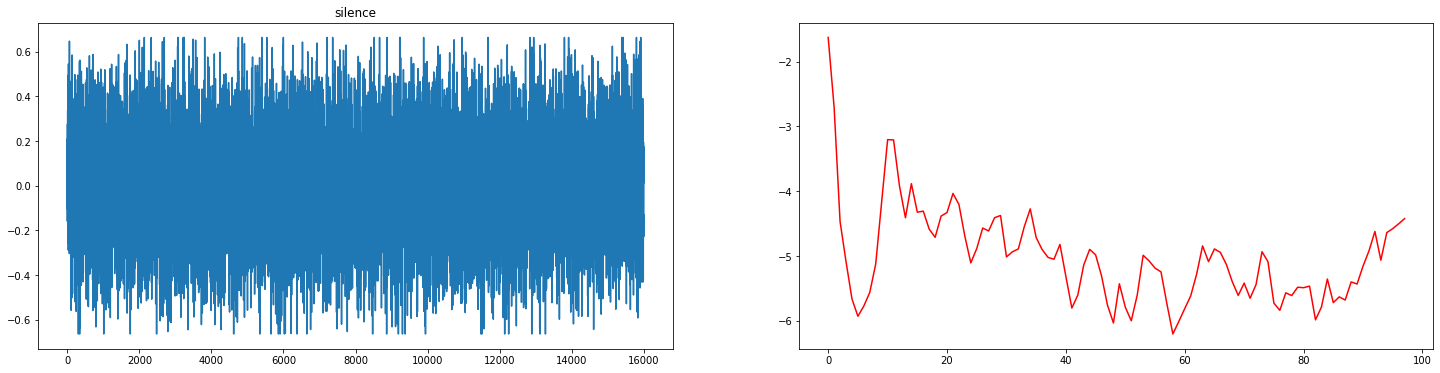

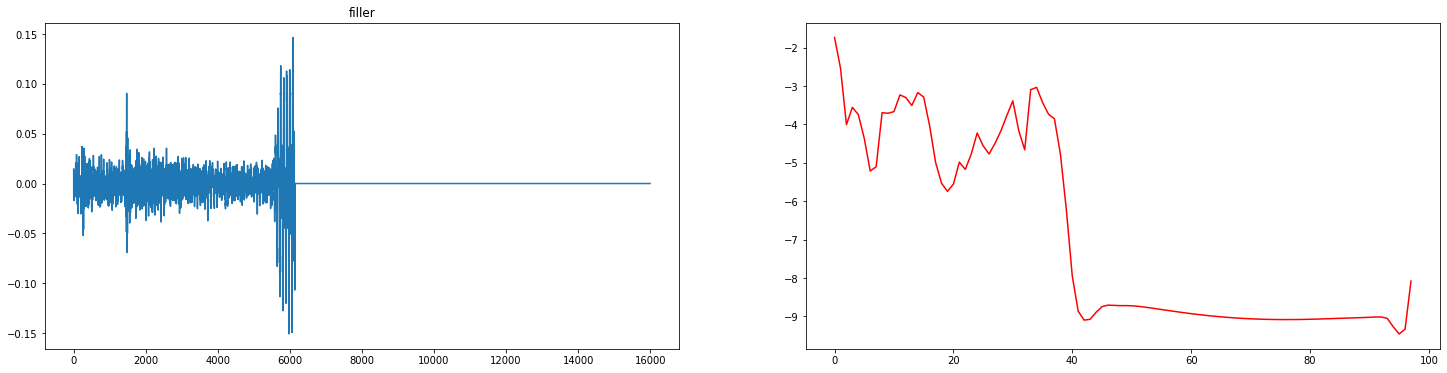

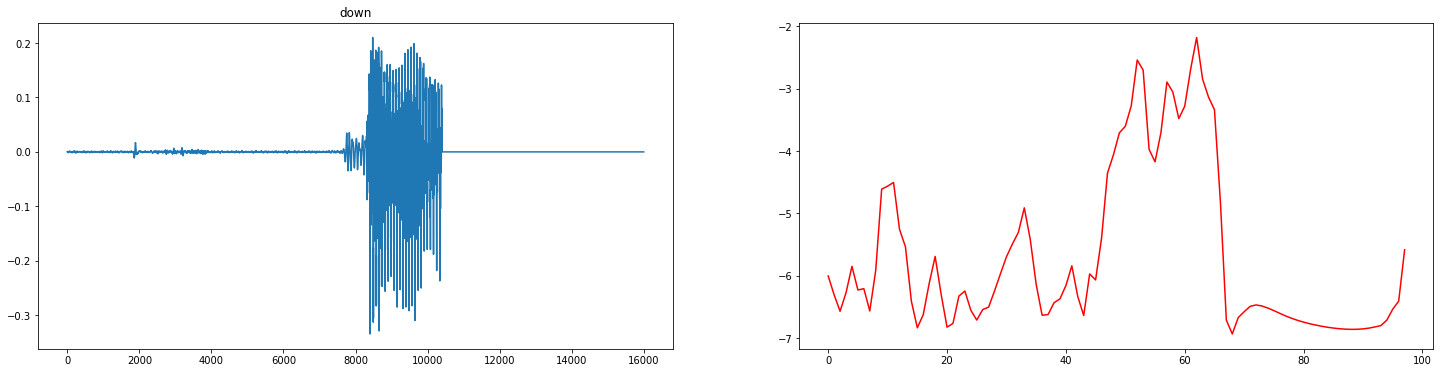

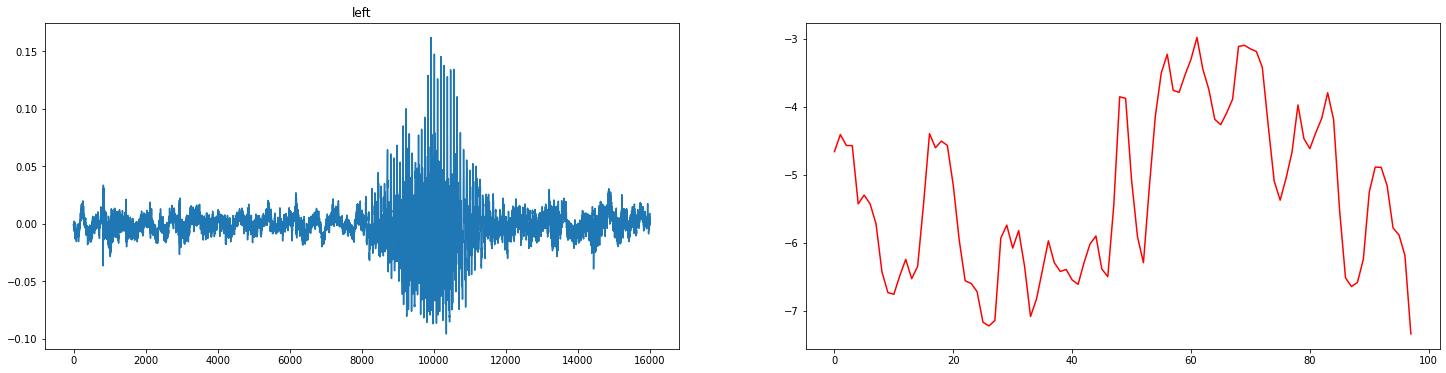

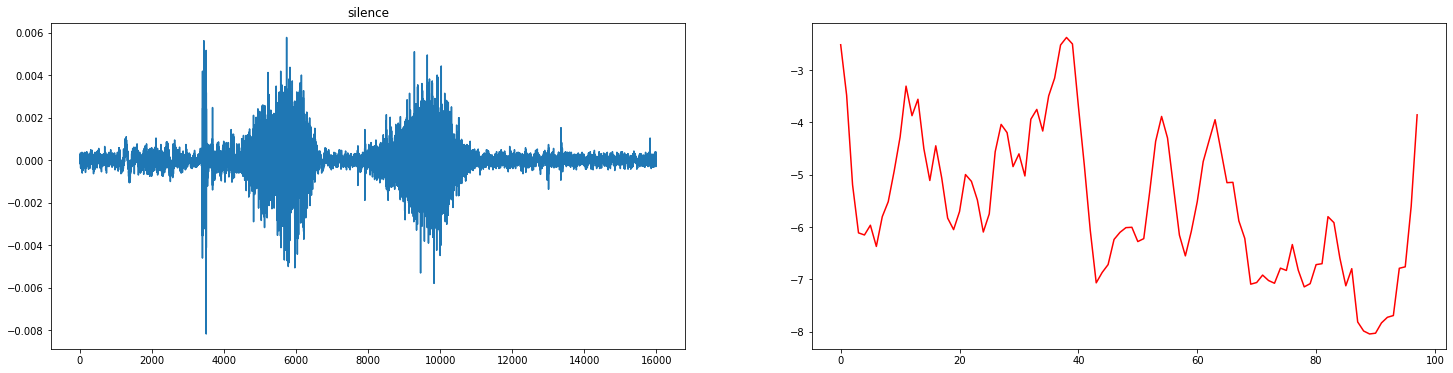

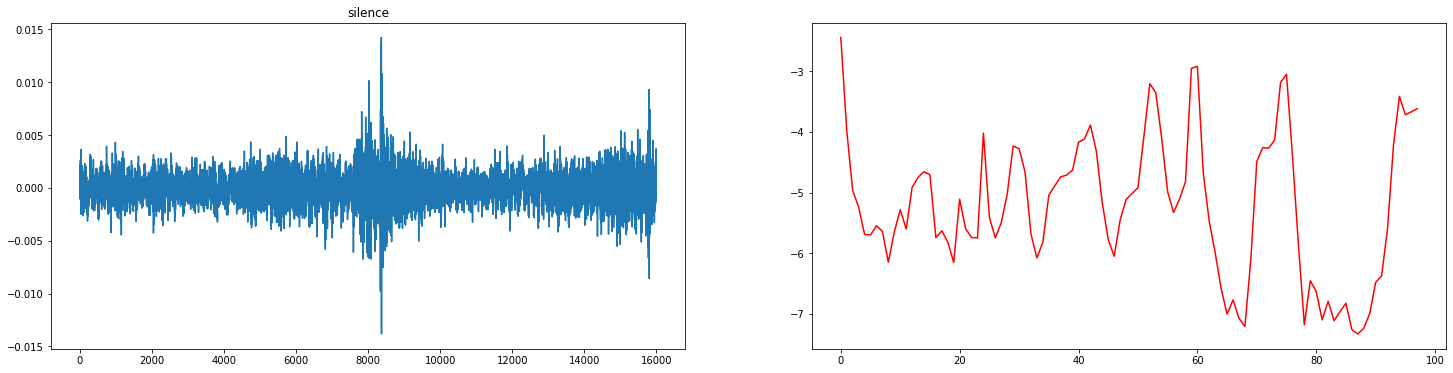

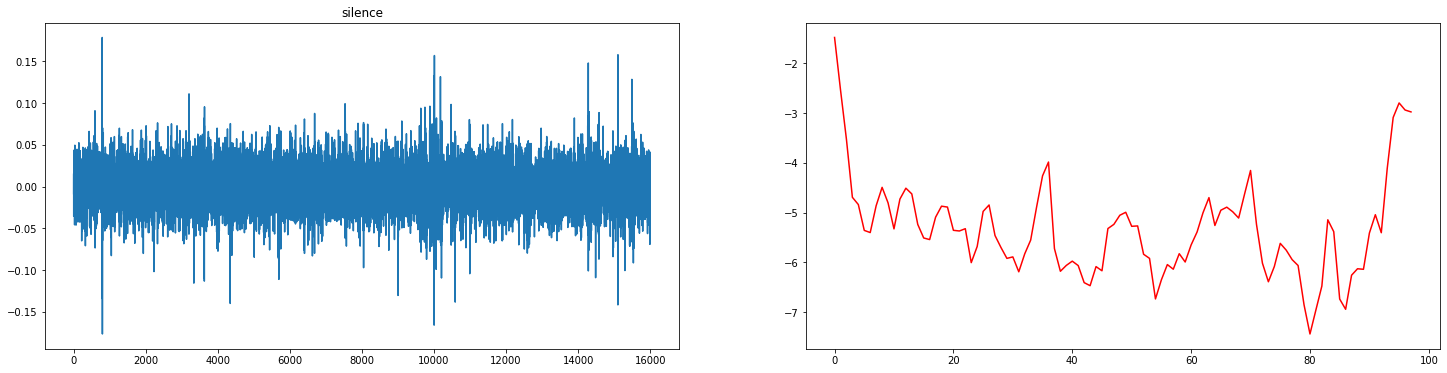

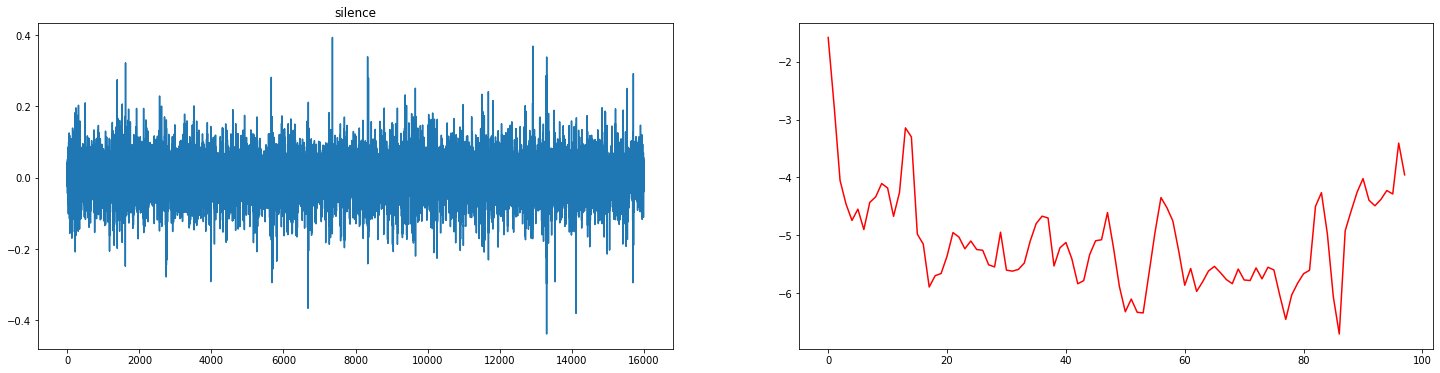

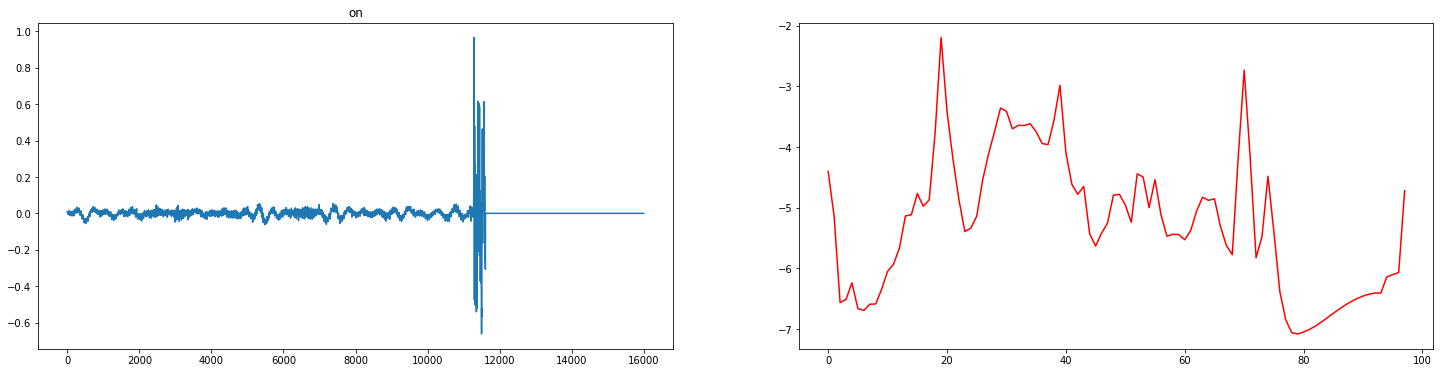

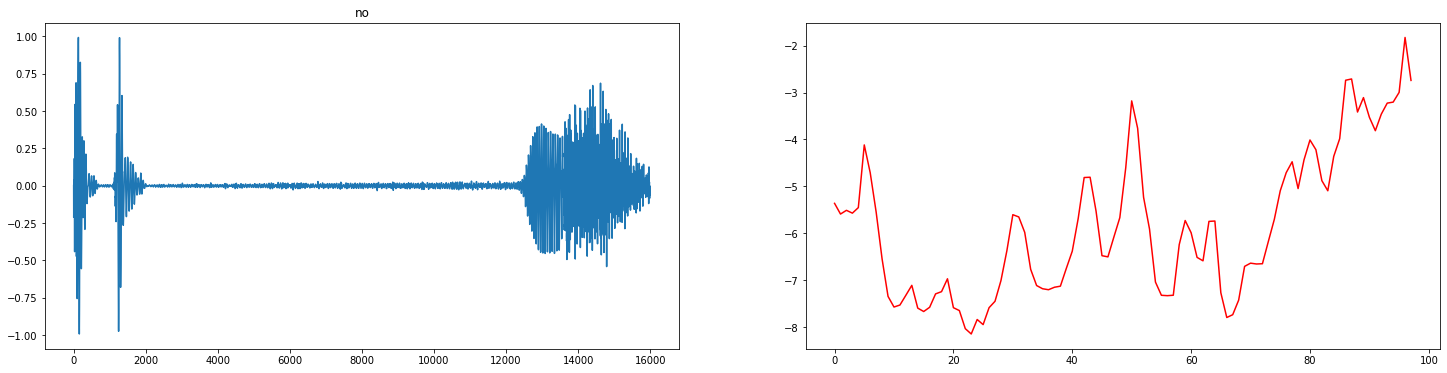

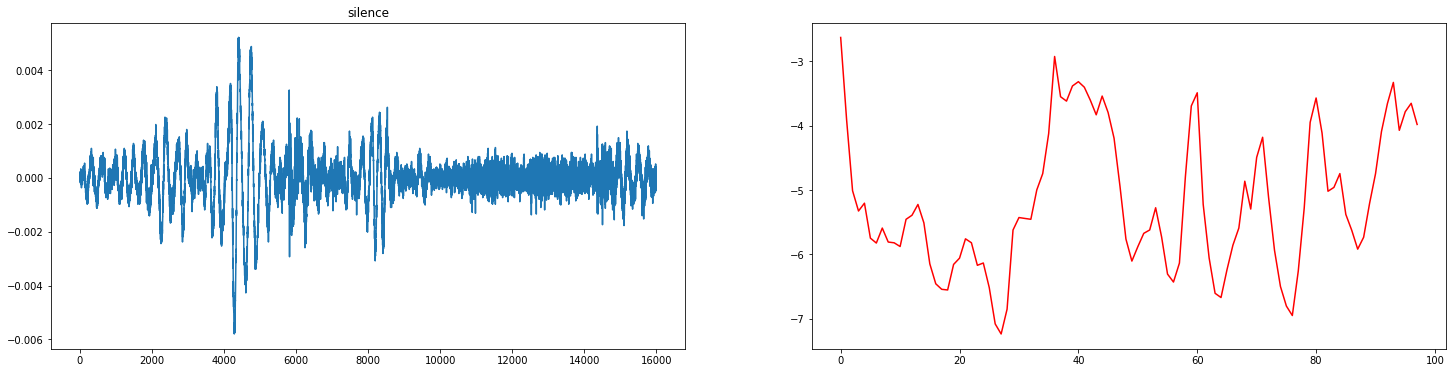

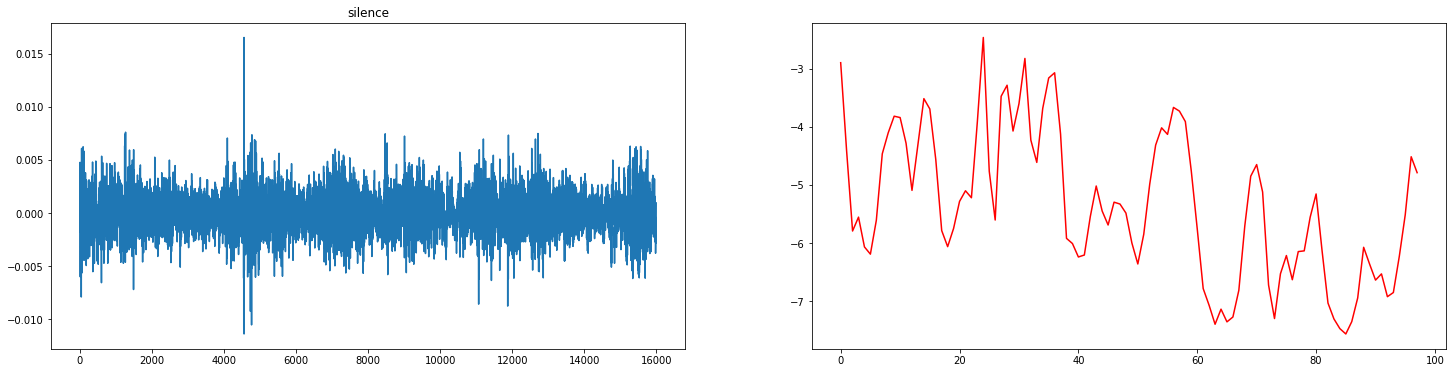

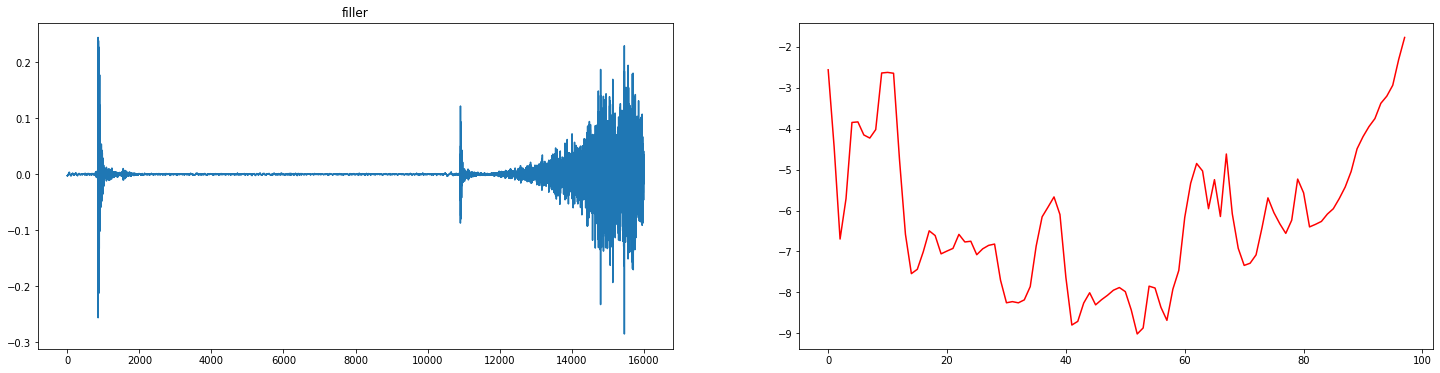

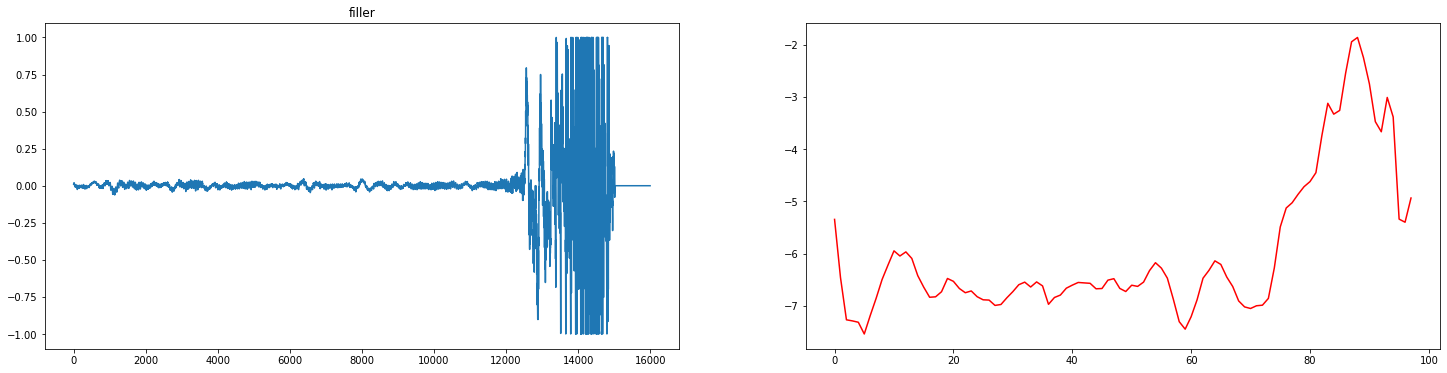

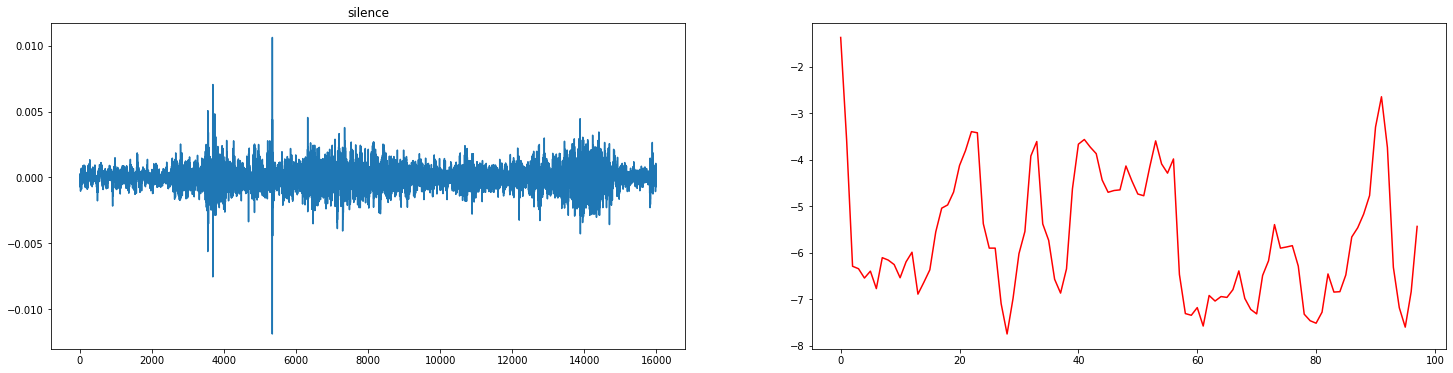

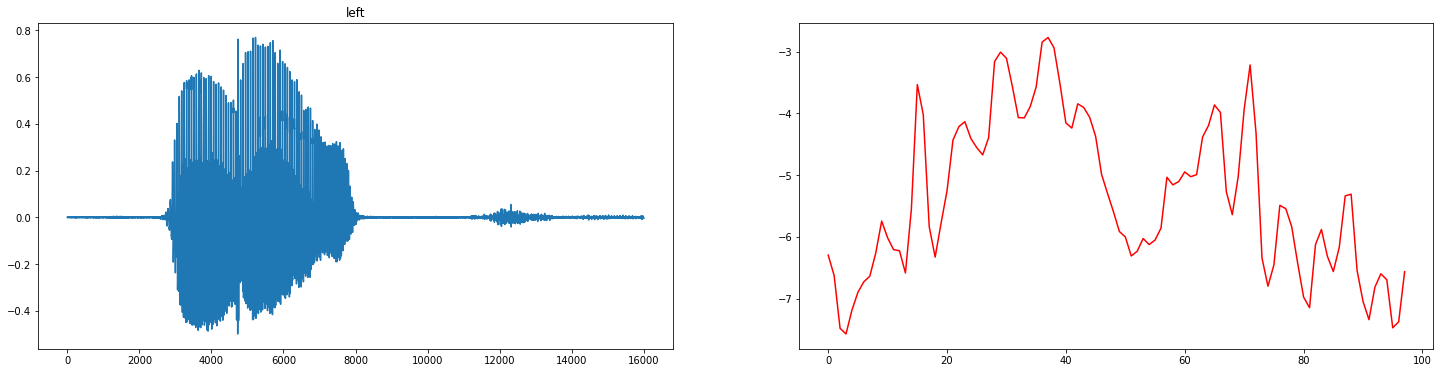

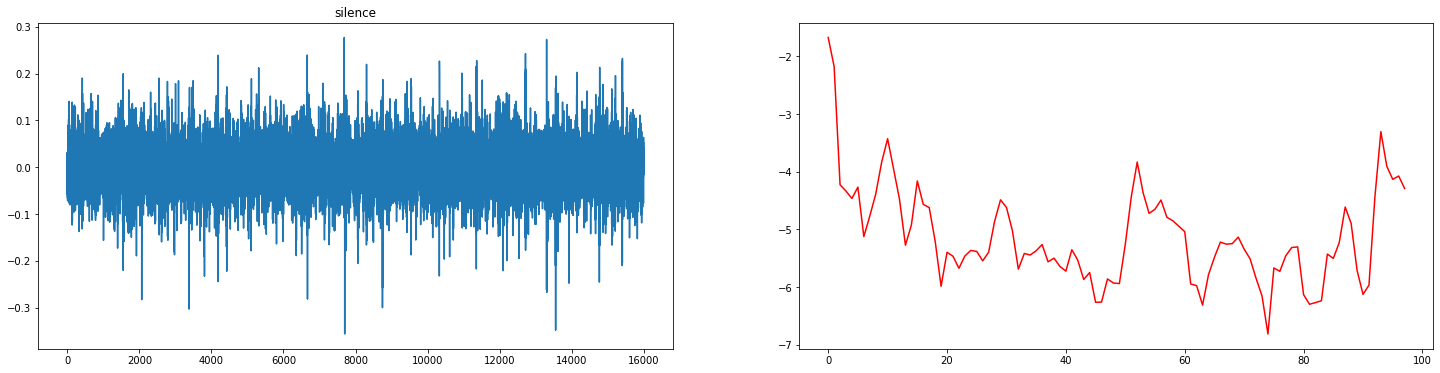

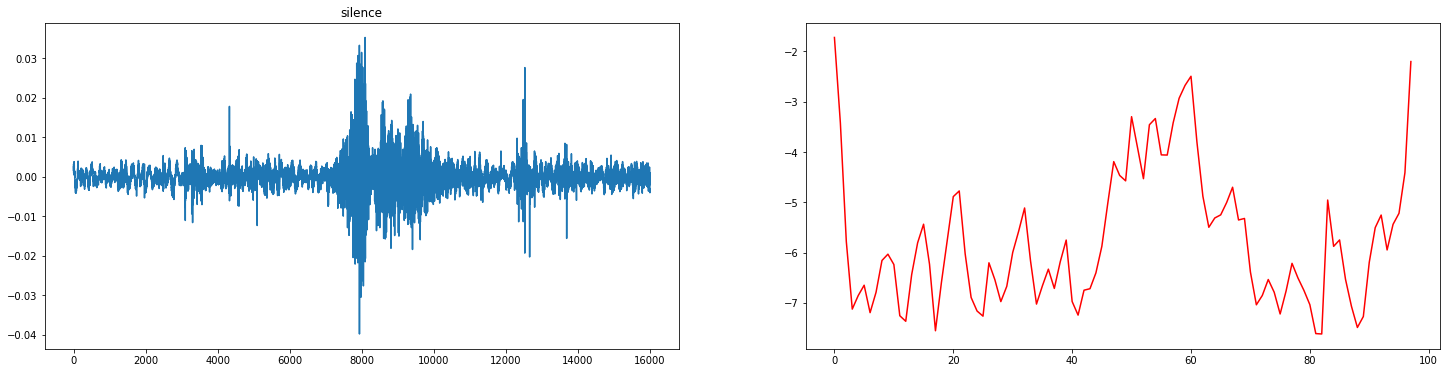

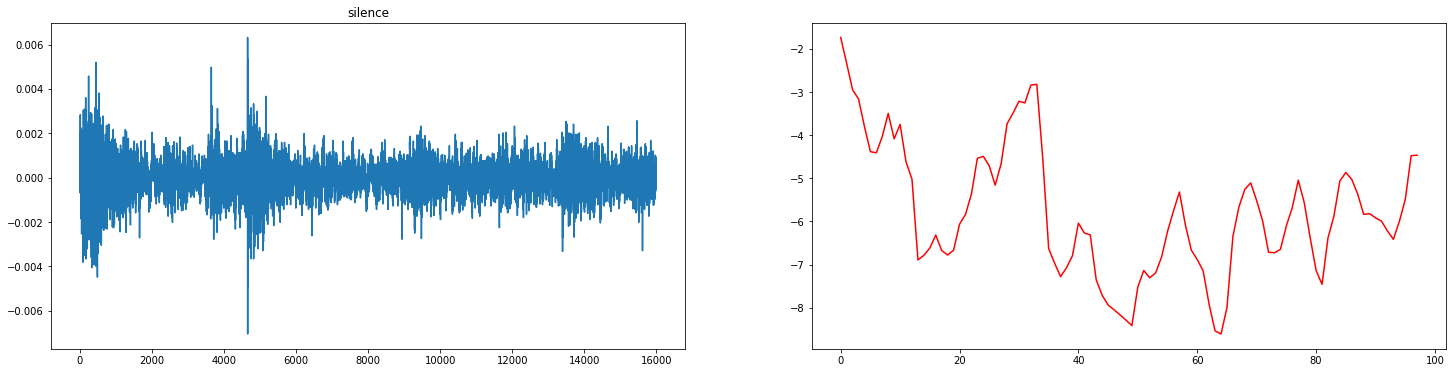

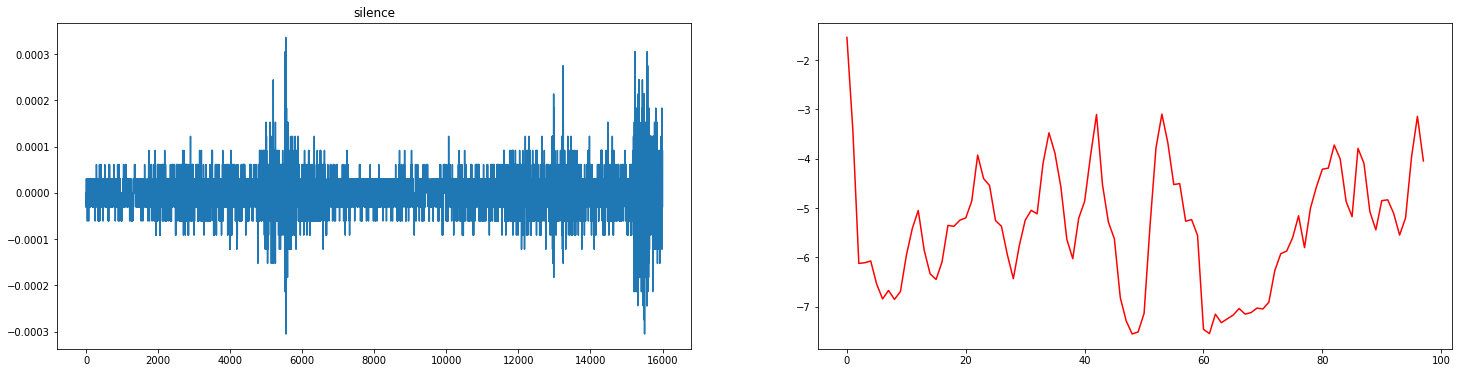

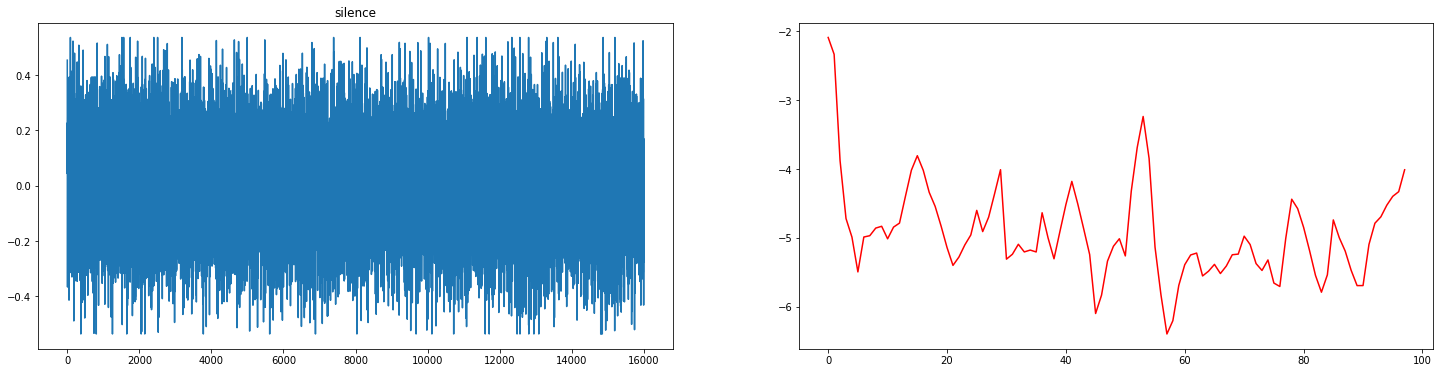

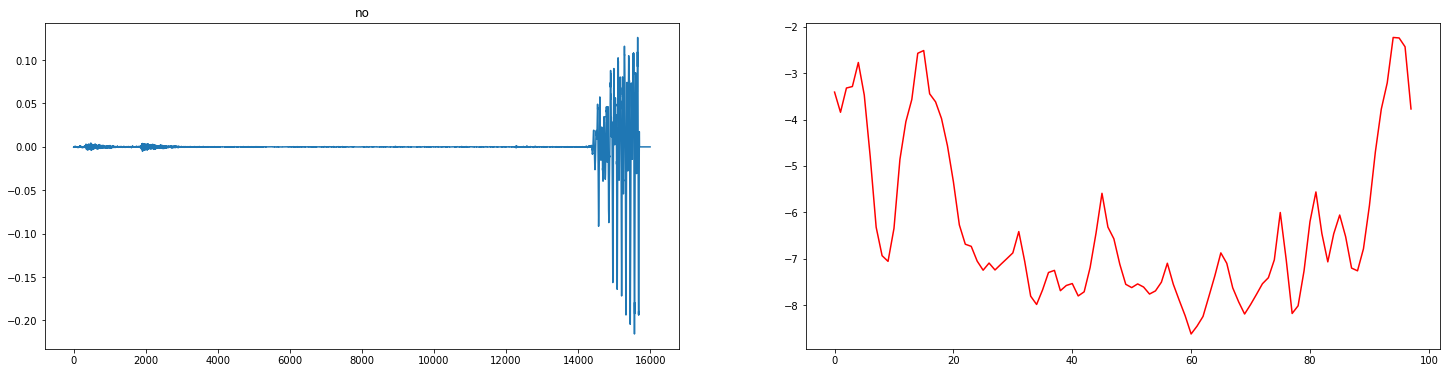

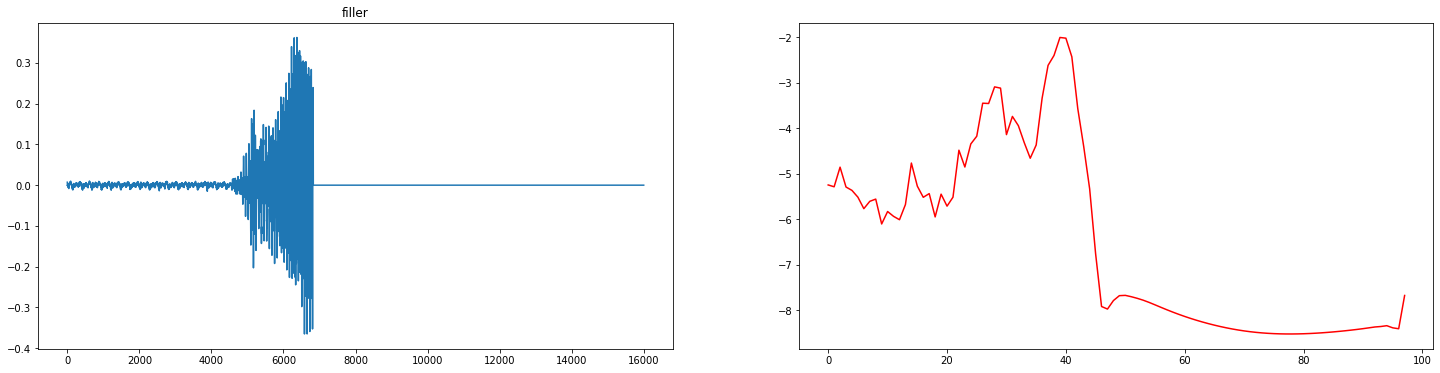

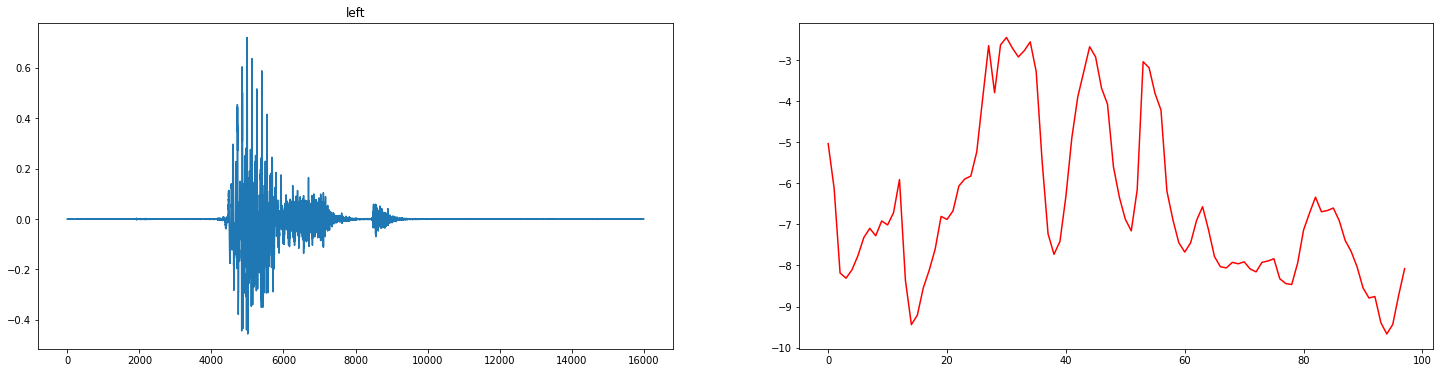

In [42]:

for i in wrongs:
    plt.figure(figsize=(25,6))
    fname = X_test[i]
    w = decode_audio(fname)
    plt.subplot(1,2,1)
    plt.plot(w)
    plt.title(output_classes[get_test_label_int(fname)])
    plt.subplot(1,2,2)
    plt.plot(atts[i], color='r')
    plt.show()
    
    display.display(display.Audio(w, rate=16000))
    

In [ ]:
log_att_tot = np.log(atts + 0.00001)

plt.plot(tf.reduce_mean(log_att_tot, axis=0))

Here the model computes a number equal to `num_heads` vectors of attention weights. If avaraged together, they give an idea of where the attention is concentrated.

## Keyword Transformer

In [7]:
kwt = KWT(train_dataset, model_suffix = "test_train",
                 num_patches=98,
                 num_layers=10,
                 d_model=192,
                 num_heads=3,
                 mlp_dim=768,
                 output_classes=output_classes,
                 mfccs=False)

Input shape: (16000,)


2021-08-25 00:14:15.512522: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
kwt.summary()

Model: "KWT_test_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
random_noise_augment (Random (None, 16000)             0         
_________________________________________________________________
log_mel_spectrogram (LogMelS (None, 98, 81, 1)         0         
_________________________________________________________________
remove_energies (Lambda)     (None, 98, 80, 1)         0         
_________________________________________________________________
spec_augment (SpecAugment)   (None, 98, 80, 1)         0         
_________________________________________________________________
removeChannelDimension (Lamb (None, 98, 80)            0         
_________________________________________________________________
dense (Dense)                (None, 98, 192)        

In [9]:
# tf.keras.utils.plot_model(test_model)

In [10]:
kwt.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history =kwt.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/2


2021-08-25 00:14:25.839534: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-25 00:14:25.915272: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-25 00:14:26.158488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


124/741 [====>.........................] - ETA: 6:35 - loss: 3.7371 - out_layer_loss: 3.7371 - out_layer_accuracy: 0.0370

KeyboardInterrupt: 

In [11]:
kwt.save_weights(hyperparams._MODELS_DIR_/current_task/kwt.name/f"{kwt.name}_weights")
# model_att_andreade.load_weights(hyperparams._MODELS_DIR_/current_task/model_att_andreade.name/f"{model_att_andreade.name}_weights")


KeyError: 'accuracy'

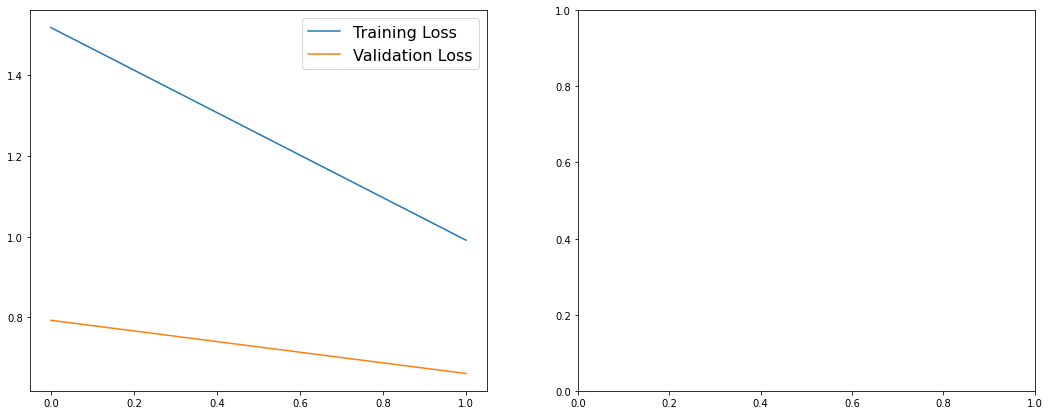

In [12]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

2021-08-24 23:30:22.746207: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 574887456 exceeds 10% of free system memory.


Test set accuracy: 78.089%


2021-08-24 23:30:25.955893: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 575122680 exceeds 10% of free system memory.


Test set accuracy canonical test set: 77.546%


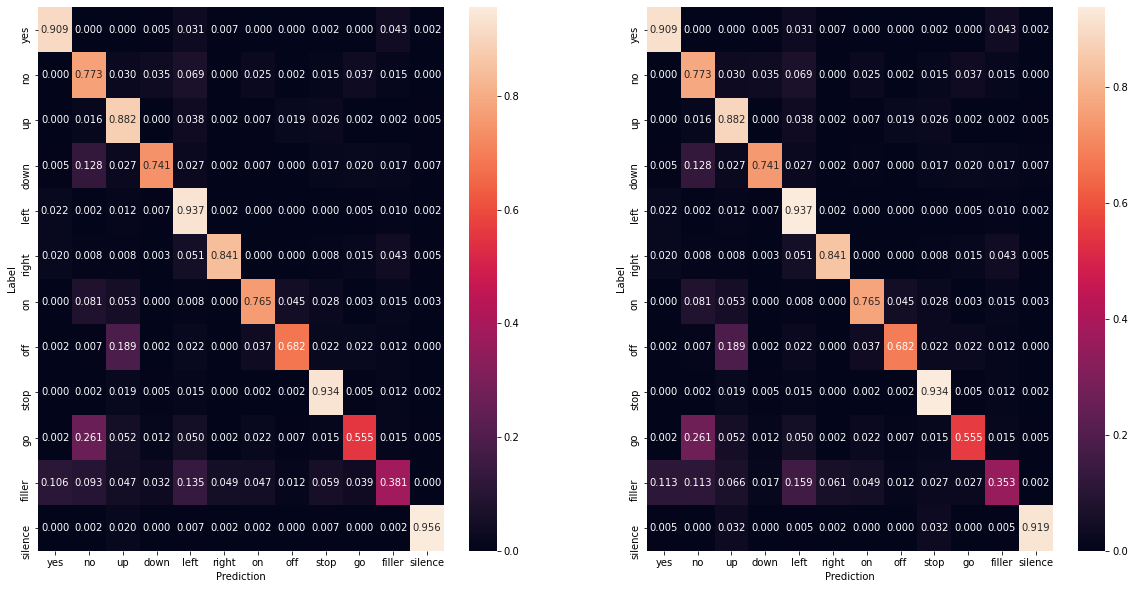

In [14]:
y_scores = kwt.predict(test_dataset.batch(batch_size))[0]
y_true = np.array(y_test)

# y_scores = model_att_andreade.predict(valid_dataset, steps=valid_steps)[0][:len(y_valid)]
# y_true = np.array(y_valid)

y_pred = np.array(np.argmax(y_scores, axis=1))
# compute test accuracy
test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".3f")
plt.xlabel('Prediction')
plt.ylabel('Label')

#canonical test set ----------------------------------------------------
y_scores2 = kwt.predict(test_dataset_can.batch(batch_size))[0]
y_true2 = np.array(y_test_can)

y_pred2 = np.array(np.argmax(y_scores2, axis=1))
# compute test accuracy
test_acc_can = sum(np.equal(y_pred2, y_true2)) / len(y_true2)
print(f'Test set accuracy canonical test set: {test_acc_can:.3%}')

plt.subplot(1,2,2)
confusion_mtx2 = confusion_matrix(y_true2, y_pred2, normalize='true') 
sns.heatmap(confusion_mtx2, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".3f")
plt.xlabel('Prediction')
plt.ylabel('Label')

plt.show()

In [15]:
atts = kwt.predict(test_dataset.batch(batch_size))[1]

2021-08-24 23:30:50.312435: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 574887456 exceeds 10% of free system memory.


## ResNet

In [8]:
resnetkws = kws_res_net(train_dataset, output_classes, model_suffix="test_train", mfccs=True)

Input shape: (16000,)


2021-08-26 00:35:24.668266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
resnetkws.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history =resnetkws.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/40


2021-08-26 00:35:53.808352: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-26 00:35:53.897254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-26 00:35:54.149401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-26 00:35:54.181061: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-26 00:35:54.445478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


 89/324 [=======>......................] - ETA: 31s - loss: 2.5219 - accuracy: 0.2624

KeyboardInterrupt: 